# Разведочный анализ данных

## Описание

Основная задача проекта – выявить ключевые темы обсуждений у 18 активных чатов и каналов выпускных сообществ Яндекс Практикума, определить, какие из них наиболее интересны аудитории, и на основе этого формировать информативные дайджесты для выпускников.

**Контекст**

- необходимо провести первичный анализ сообщений,

**Что нужно сделать?**

1. кто пишет часто
2. в какое время чаще всего пишут пользователи
3. сколько пишут сообщений сколько
4. анализ времени → пики активности, дни недели.
5. подумать, что можно еще посчитать полезного
6. какие темы обсуждали
7. какие слова использовали
8. какое настроение

**Результат:**

- код .py, .ipynb
- csv/xlsx файл со статистикой

## Библиотеки

In [1]:
import logging
import os
import warnings
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import networkx as nx
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ast
from wordcloud import WordCloud
from collections import Counter
from pyvis.network import Network



# Настройка параметров matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

# Настройка стиля seaborn
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

## Загрузка датасетов

In [2]:
manage_alumin = pd.read_csv('.\datasets\MANAGEMENT ALUMNI PRACTICUM.csv')
data_practicum = pd.read_csv('.\datasets\Data Practicum Chat.csv')
marketing_chat = pd.read_csv('.\datasets\Marketing Practicum Chat.csv')


print('Загрузка MANAGEMENT ALUMNI PRACTICUM:', manage_alumin.shape, 'загрузка Data Practicum Chat:', 
data_practicum.shape, 'загрузка Marketing Practicum Chat:', marketing_chat.shape)

Загрузка MANAGEMENT ALUMNI PRACTICUM: (13, 18) загрузка Data Practicum Chat: (1007, 36) загрузка Marketing Practicum Chat: (3680, 31)


# ==============================================
# БЛОК 1: ПОДГОТОВКА ДАННЫХ
# ==============================================

In [3]:

def preprocess_df(df):
    """Предобработка данных"""
    # Преобразование даты
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    
    # Обработка текста
    if 'text' in df.columns:
        try:
            # Пробуем преобразовать из JSON строки
            import ast
            df['text'] = df['text'].apply(ast.literal_eval)
            df['text_clean'] = df['text'].apply(lambda x: x[0]['text'] if x else '')
        except:
            # Если не получается, оставляем как есть
            df['text_clean'] = df['text'].fillna('')
    
    # Добавляем временные метрики
    df['hour'] = df['date'].dt.hour
    df['day_of_week'] = df['date'].dt.day_name()
    df['date_only'] = df['date'].dt.date
    
    return df



print("Предобработка данных...")
manage_alumin = preprocess_df(manage_alumin)
data_practicum = preprocess_df(data_practicum)
marketing_chat = preprocess_df(marketing_chat)

Предобработка данных...


# ==============================================
# БЛОК 2: АНАЛИЗ АКТИВНЫХ ПОЛЬЗОВАТЕЛЕЙ
# ==============================================



Анализ активных пользователей в MANAGEMENT ALUMNI:


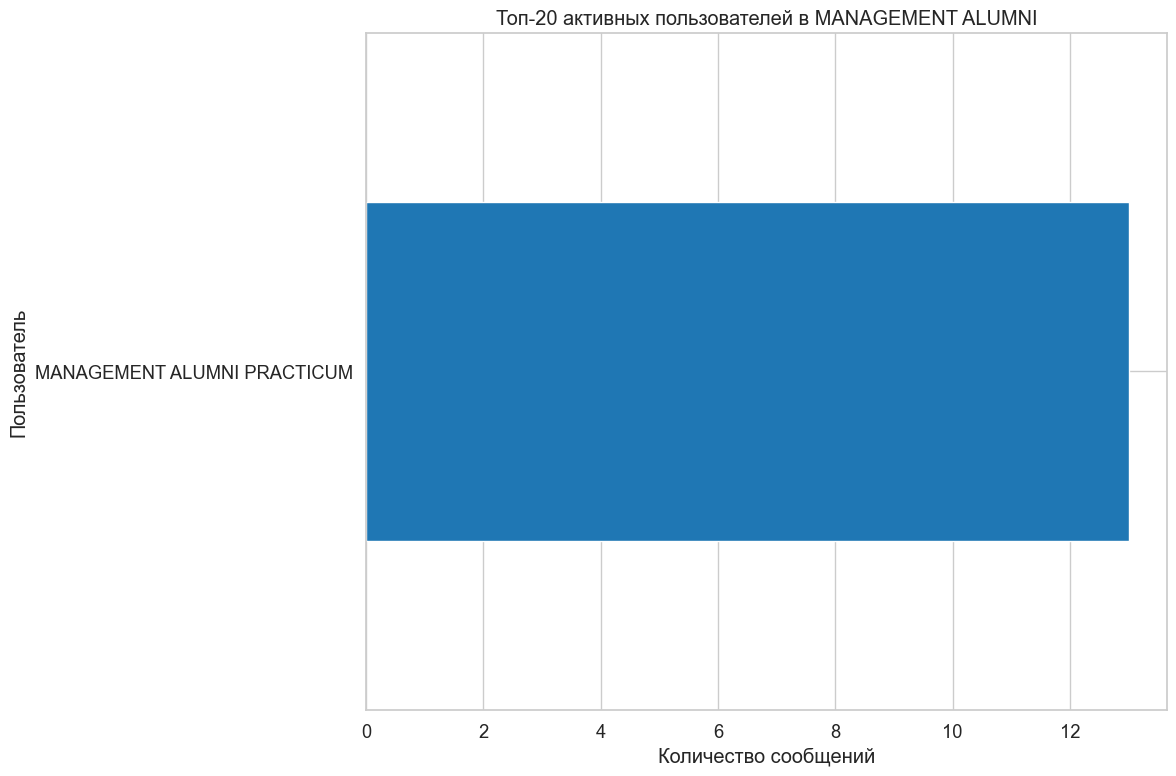


Анализ активных пользователей в DATA PRACTICUM:


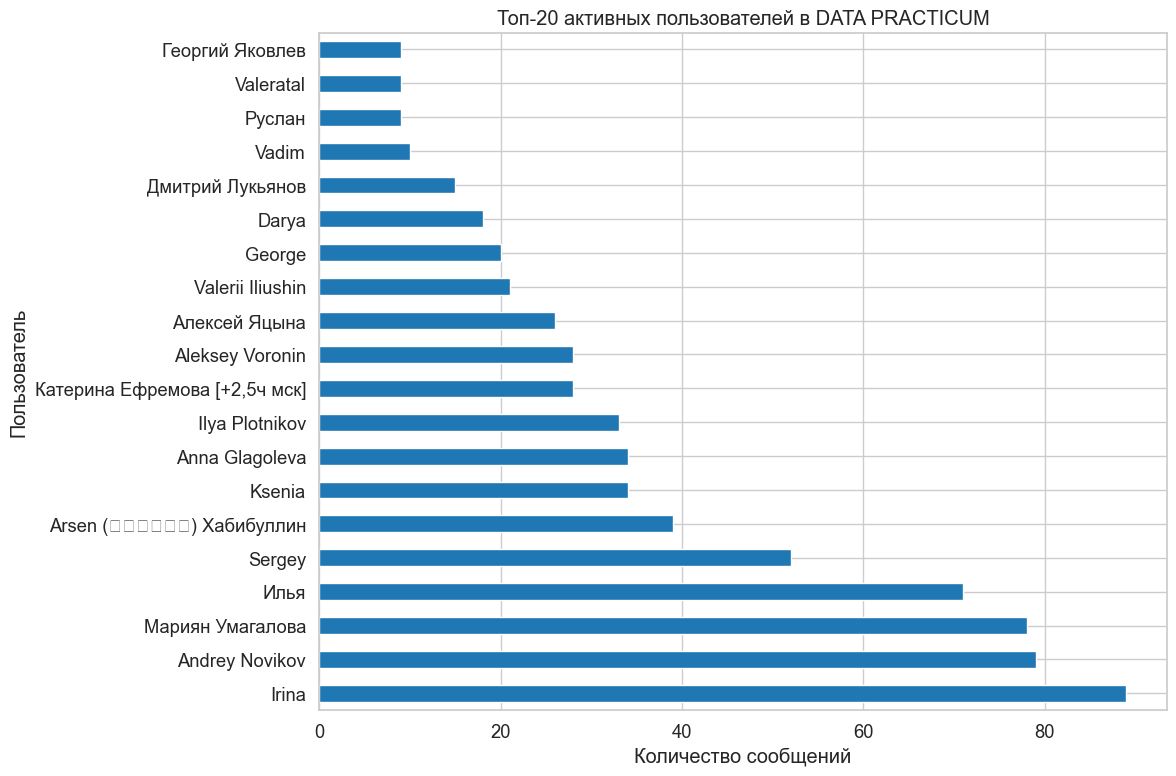


Анализ активных пользователей в MARKETING CHAT:


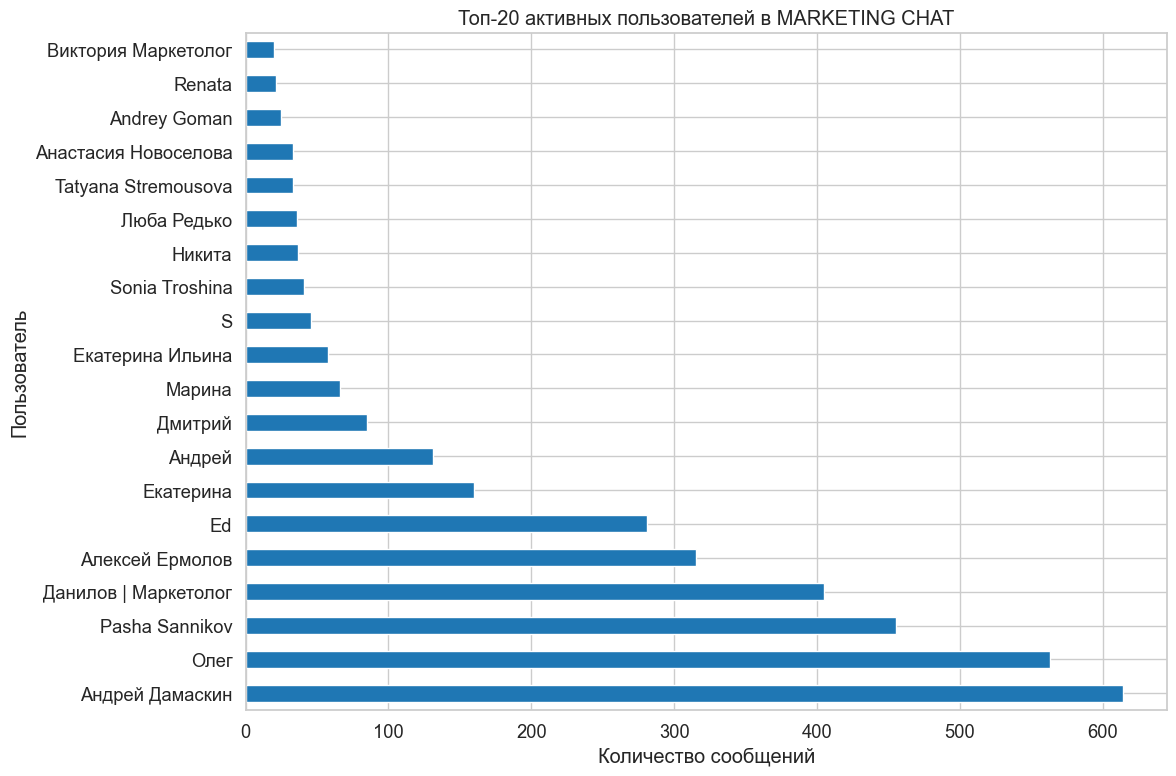

In [4]:

def analyze_active_users(df, chat_name):
    """Анализ самых активных пользователей"""
    print(f"\nАнализ активных пользователей в {chat_name}:")
    
    # Топ-20 пользователей по количеству сообщений
    user_activity = df['from'].value_counts().head(20)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    user_activity.plot(kind='barh')
    plt.title(f'Топ-20 активных пользователей в {chat_name}')
    plt.xlabel('Количество сообщений')
    plt.ylabel('Пользователь')
    plt.tight_layout()
    plt.show()
    
    return user_activity


active_users_manage = analyze_active_users(manage_alumin, "MANAGEMENT ALUMNI")
active_users_data = analyze_active_users(data_practicum, "DATA PRACTICUM")
active_users_marketing = analyze_active_users(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 3: АНАЛИЗ ВРЕМЕННЫХ ПАТТЕРНОВ
# ==============================================



Анализ временных паттернов в MANAGEMENT ALUMNI:


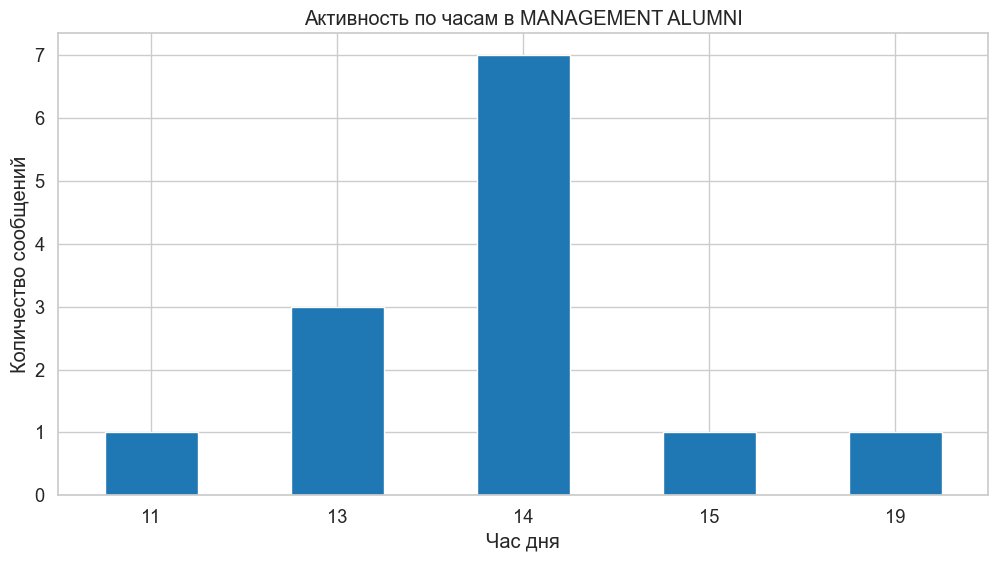

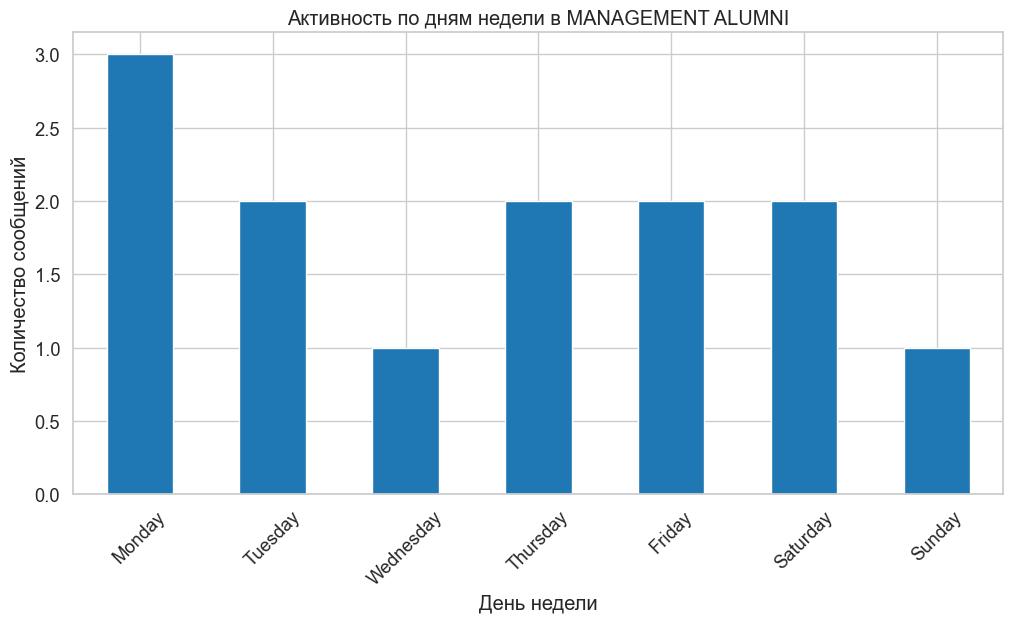

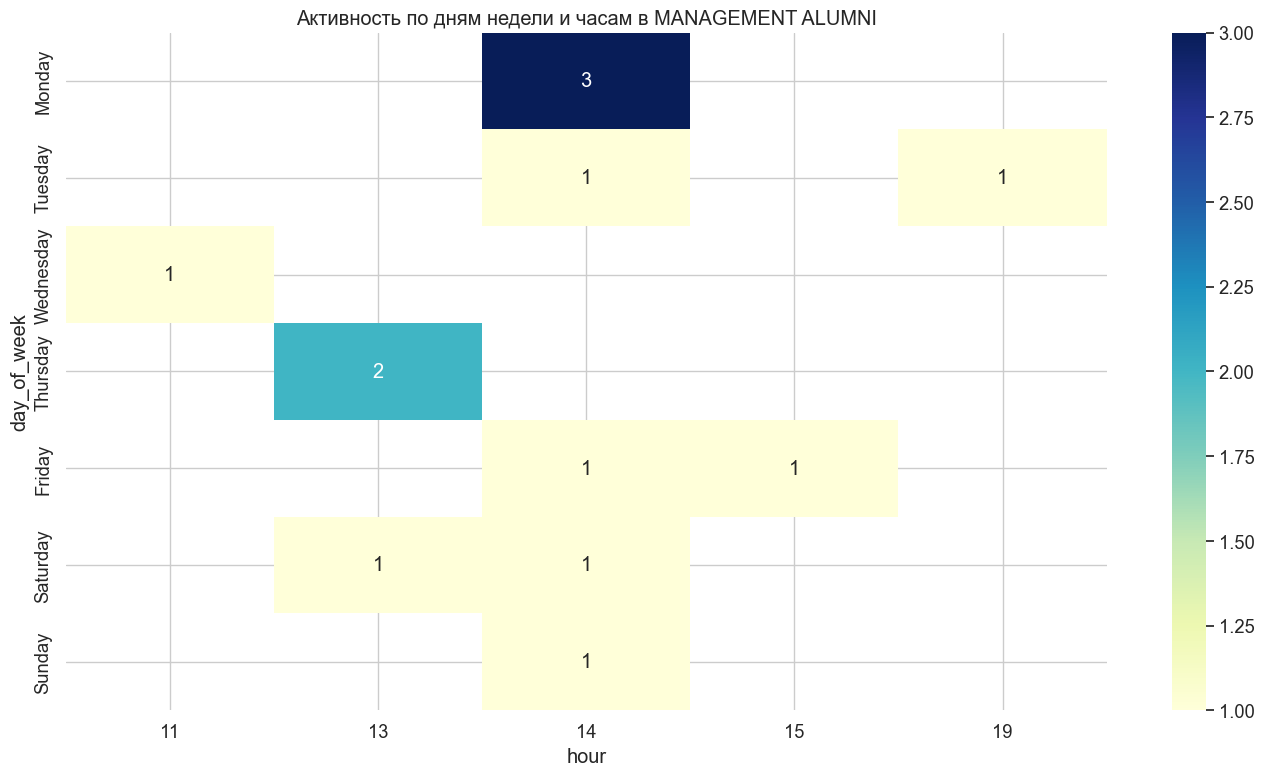


Анализ временных паттернов в DATA PRACTICUM:


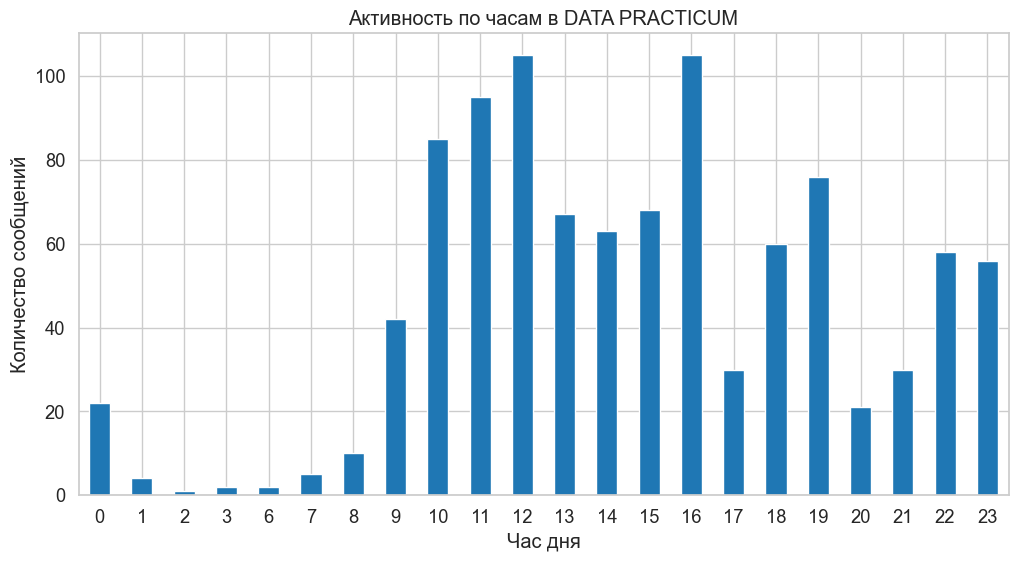

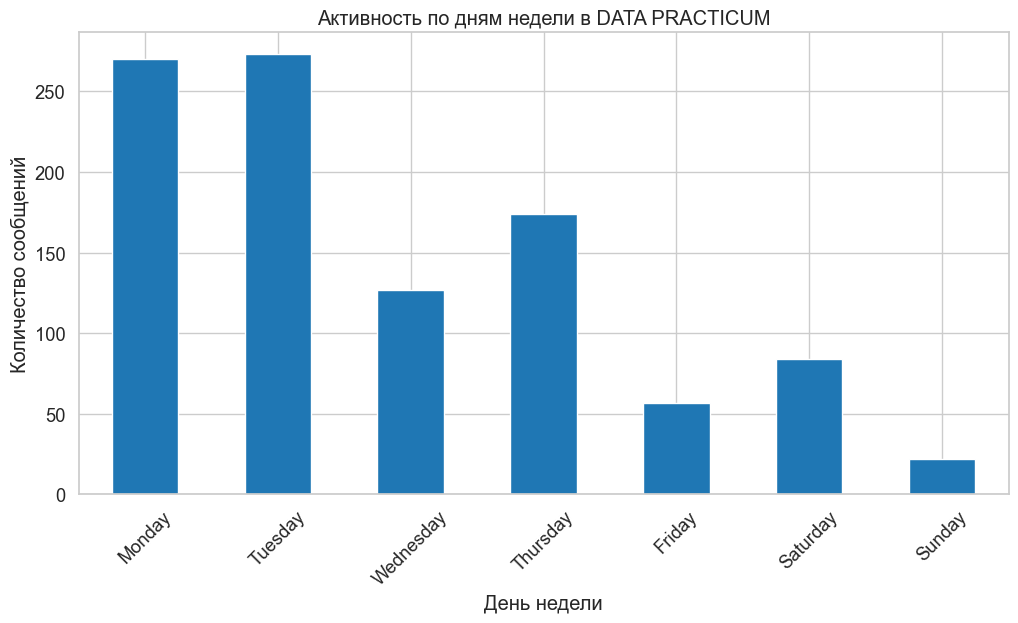

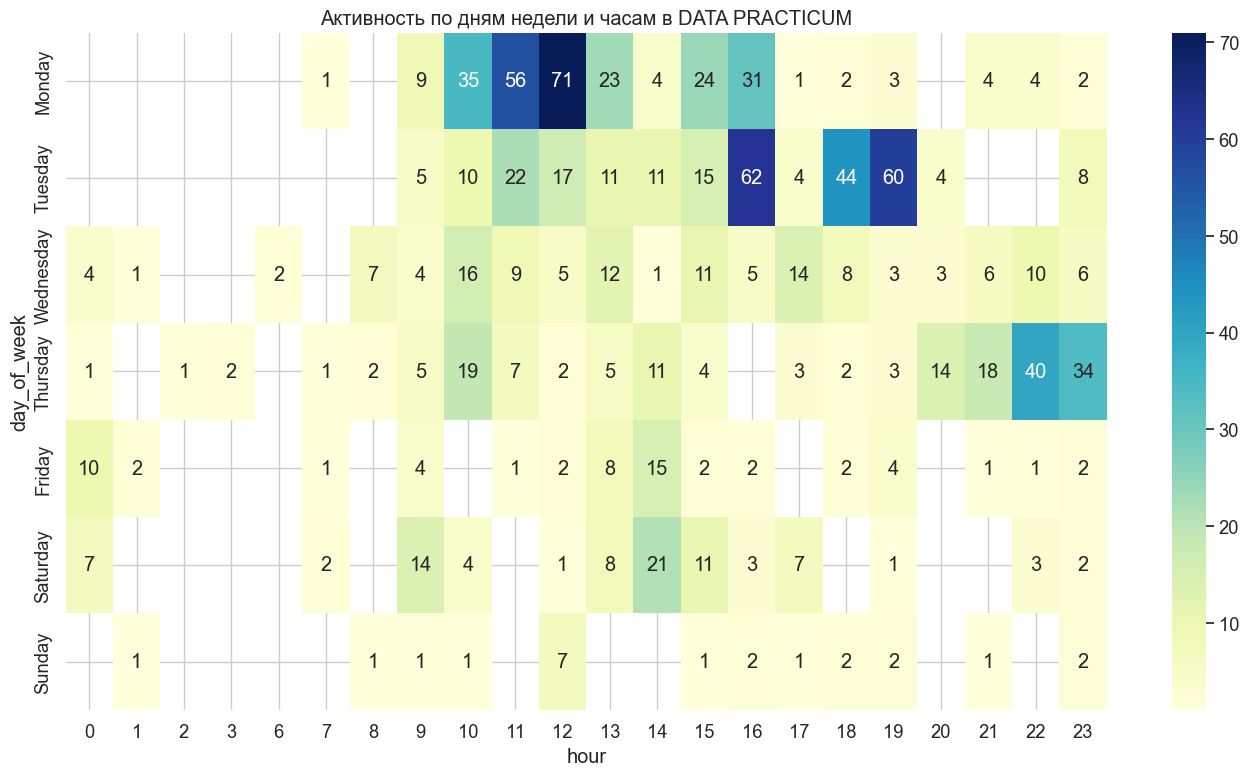


Анализ временных паттернов в MARKETING CHAT:


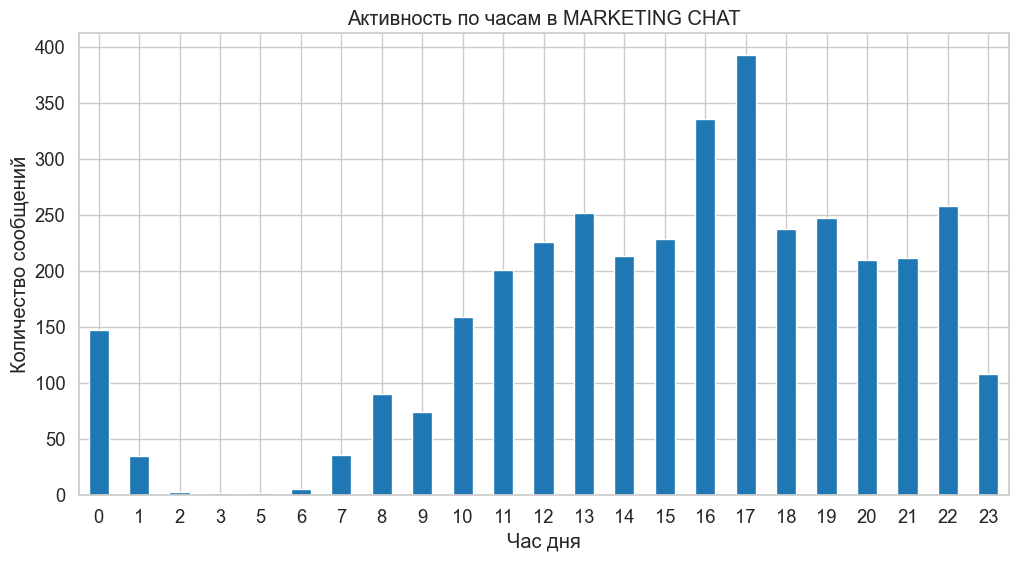

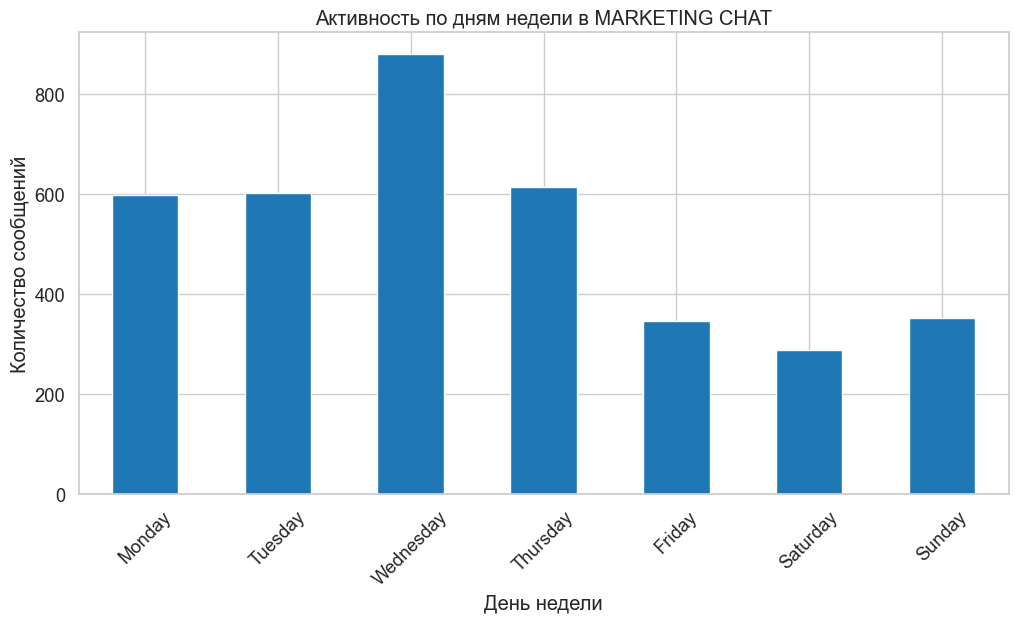

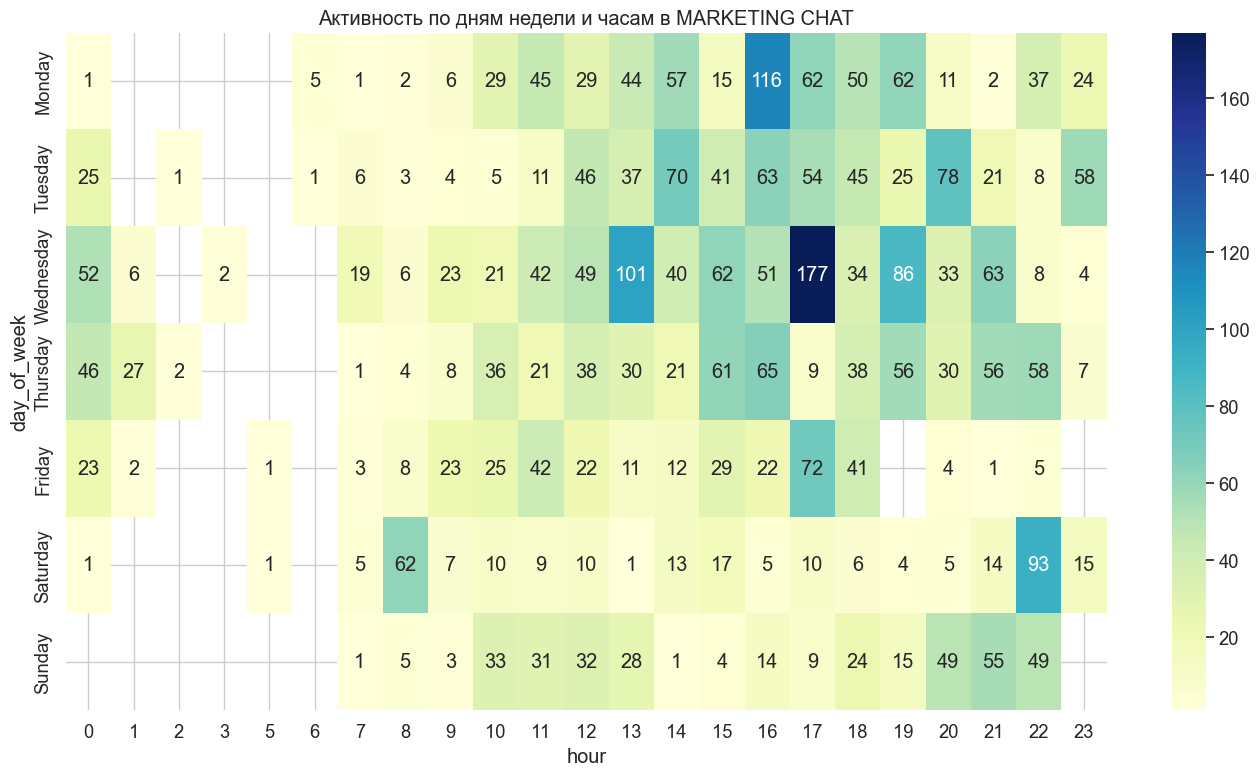

In [5]:

def analyze_time_patterns(df, chat_name):
    """Анализ активности по времени"""
    print(f"\nАнализ временных паттернов в {chat_name}:")
    
    # Активность по часам
    hourly_activity = df['hour'].value_counts().sort_index()
    
    plt.figure(figsize=(12, 6))
    hourly_activity.plot(kind='bar')
    plt.title(f'Активность по часам в {chat_name}')
    plt.xlabel('Час дня')
    plt.ylabel('Количество сообщений')
    plt.xticks(rotation=0)
    plt.show()
    
    # Активность по дням недели
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_activity = df['day_of_week'].value_counts().reindex(days_order)
    
    plt.figure(figsize=(12, 6))
    daily_activity.plot(kind='bar')
    plt.title(f'Активность по дням недели в {chat_name}')
    plt.xlabel('День недели')
    plt.ylabel('Количество сообщений')
    plt.xticks(rotation=45)
    plt.show()
    
    # Комбинированная heatmap
    heatmap_data = df.groupby(['day_of_week', 'hour']).size().unstack().reindex(days_order)
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="g")
    plt.title(f'Активность по дням недели и часам в {chat_name}')
    plt.tight_layout()
    plt.show()
    
    return {
        'hourly_activity': hourly_activity,
        'daily_activity': daily_activity
    }


time_patterns_manage = analyze_time_patterns(manage_alumin, "MANAGEMENT ALUMNI")
time_patterns_data = analyze_time_patterns(data_practicum, "DATA PRACTICUM")
time_patterns_marketing = analyze_time_patterns(marketing_chat, "MARKETING CHAT")


# ==============================================
# БЛОК 4: АНАЛИЗ ТЕКСТОВОГО СОДЕРЖАНИЯ
# ==============================================


Анализ текстового содержания в MANAGEMENT ALUMNI:


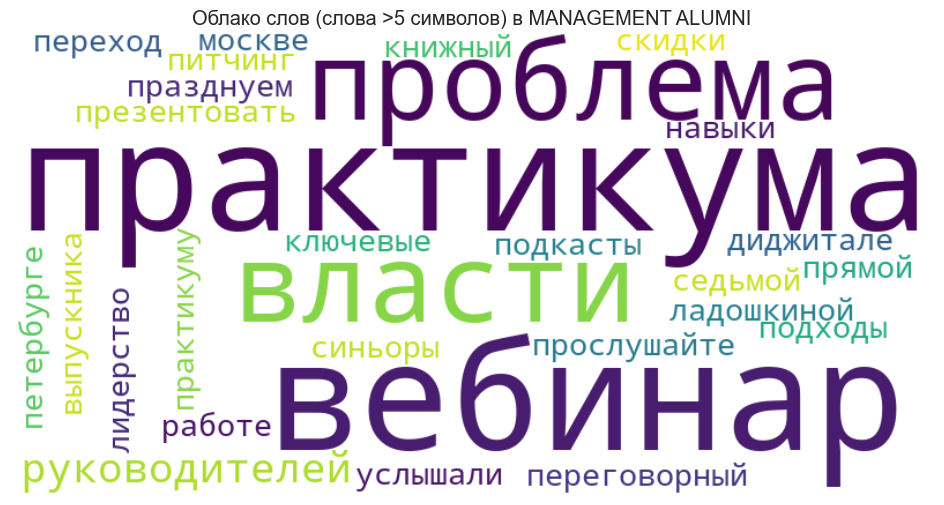

<Figure size 1200x600 with 0 Axes>

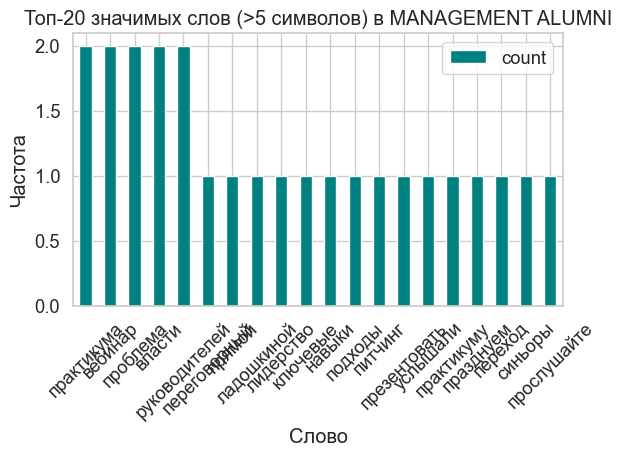


Анализ текстового содержания в DATA PRACTICUM:


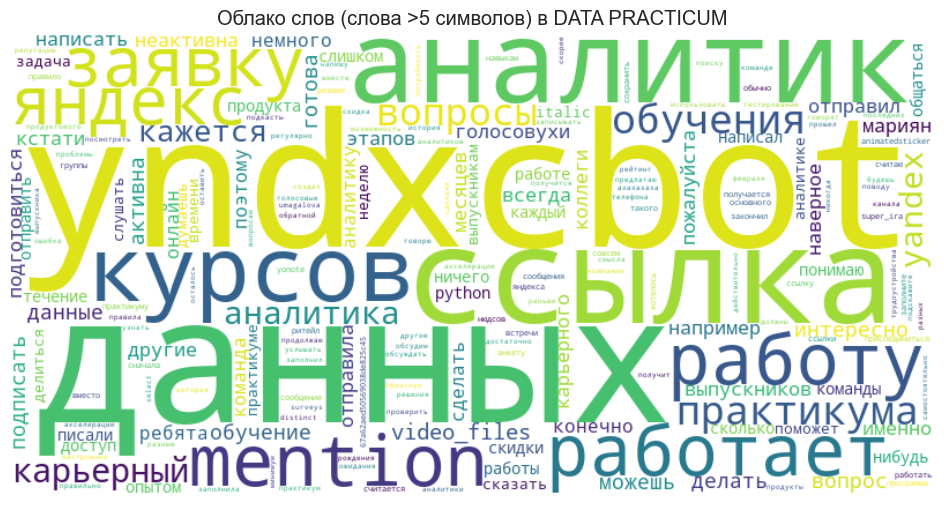

<Figure size 1200x600 with 0 Axes>

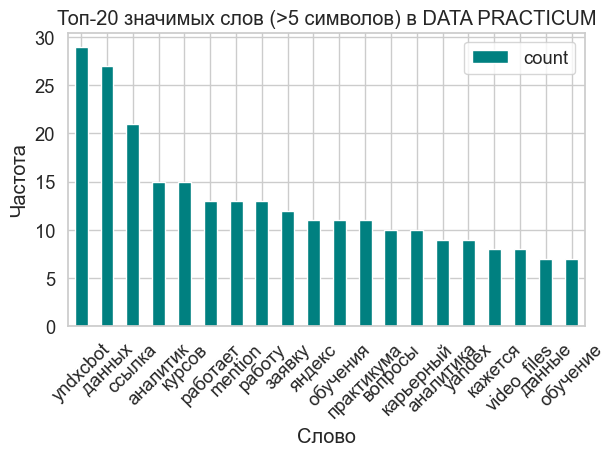


Анализ текстового содержания в MARKETING CHAT:


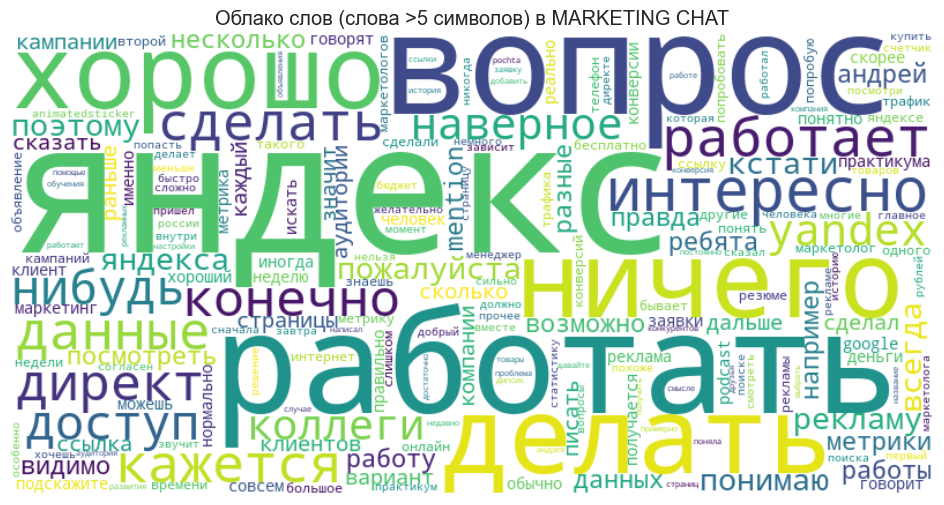

<Figure size 1200x600 with 0 Axes>

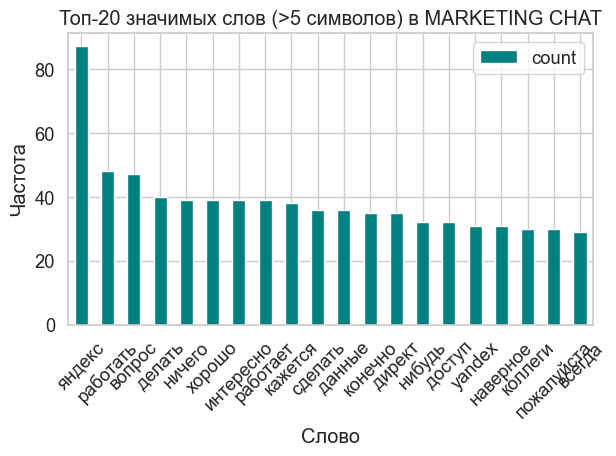

In [6]:
def analyze_text_content(df, chat_name):
    """Анализ текстового содержания"""
    print(f"\nАнализ текстового содержания в {chat_name}:")
    
    if 'text_clean' not in df.columns:
        print("Нет данных для анализа текста")
        return None
    
    # Улучшенная очистка текста
    def clean_text(text):
        if not isinstance(text, str):
            return ''
        
        # Удаляем технические артефакты
        text = re.sub(r'(type|castom_emoji|bot_command|\\n|\[|\]|\{|\}|\(|\))', '', text, flags=re.IGNORECASE)
        
        # Удаляем пунктуацию и спецсимволы (кроме букв и цифр)
        text = re.sub(r'[^\w\s]', ' ', text.lower())
        
        # Удаляем короткие слова и числа
        words = [word for word in text.split() 
                if len(word) > 5  # Берем только слова длиннее 5 символов
                and not word.isdigit()  # Исключаем числа
                and not word.startswith(('http', 'www'))]  # Исключаем ссылки
        
        return ' '.join(words)
    
    df['cleaned_text'] = df['text_clean'].apply(clean_text)
    
    # Дополнительные стоп-слова
    custom_stopwords = {
        'который', 'которые', 'когда', 'потому', 'очень', 'может', 'будет',
        'этого', 'этот', 'какой', 'какие', 'такой', 'такие', 'свой', 'свои',
        'ваш', 'ваши', 'наш', 'наши', 'чтобы', 'можно', 'нужно', 'должен',
        'custom_emoji', 'stickers', 'спасибо', 'toprep', 'document_id', 
        'только', 'просто', 'привет', 'сейчас', 'почему', 'вообще', 'спасибо',
        'sticker', 'больше', 'text_link', 'теперь', 'кажеться', 'сегодня'
    }
    
    # Облако слов с исключением стоп-слов
    all_text = ' '.join(df['cleaned_text'].dropna())
    
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white',
        stopwords=custom_stopwords,
        collocations=False
    ).generate(all_text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Облако слов (слова >5 символов) в {chat_name}')
    plt.axis('off')
    plt.show()
    
    # Топ-20 слов (исключая стоп-слова)
    words = [
        word for text in df['cleaned_text'].dropna() 
        for word in text.split() 
        if word not in custom_stopwords
    ]
    
    word_counts = Counter(words).most_common(20)
    
    if word_counts:
        plt.figure(figsize=(12, 6))
        pd.DataFrame(word_counts, columns=['word', 'count']).plot(
            x='word', y='count', kind='bar', color='teal')
        plt.title(f'Топ-20 значимых слов (>5 символов) в {chat_name}')
        plt.xlabel('Слово')
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("Не удалось выделить значимые слова после очистки")
    
    return word_counts

text_analysis_manage = analyze_text_content(manage_alumin, "MANAGEMENT ALUMNI")
text_analysis_data = analyze_text_content(data_practicum, "DATA PRACTICUM")
text_analysis_marketing = analyze_text_content(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 5: СЕТЕВОЙ АНАЛИЗ
# ==============================================


Визуализация сети чата MANAGEMENT ALUMNI:
Недостаточно данных для построения графа

Визуализация сети чата DATA PRACTICUM:


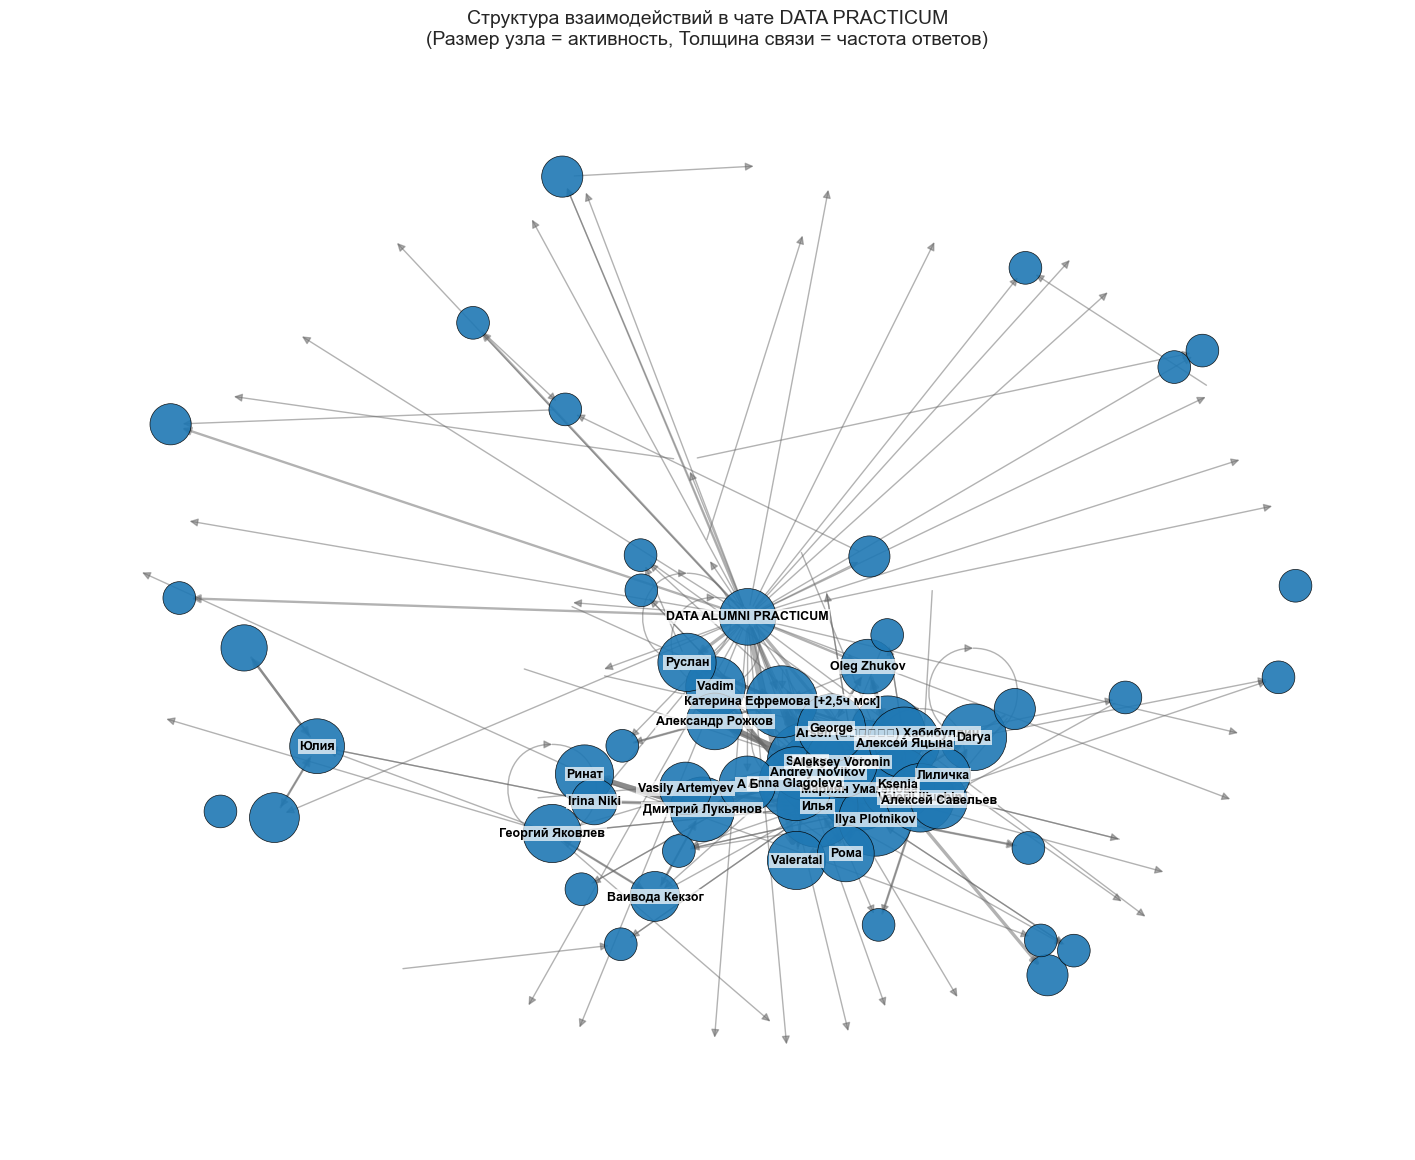


Визуализация сети чата MARKETING CHAT:


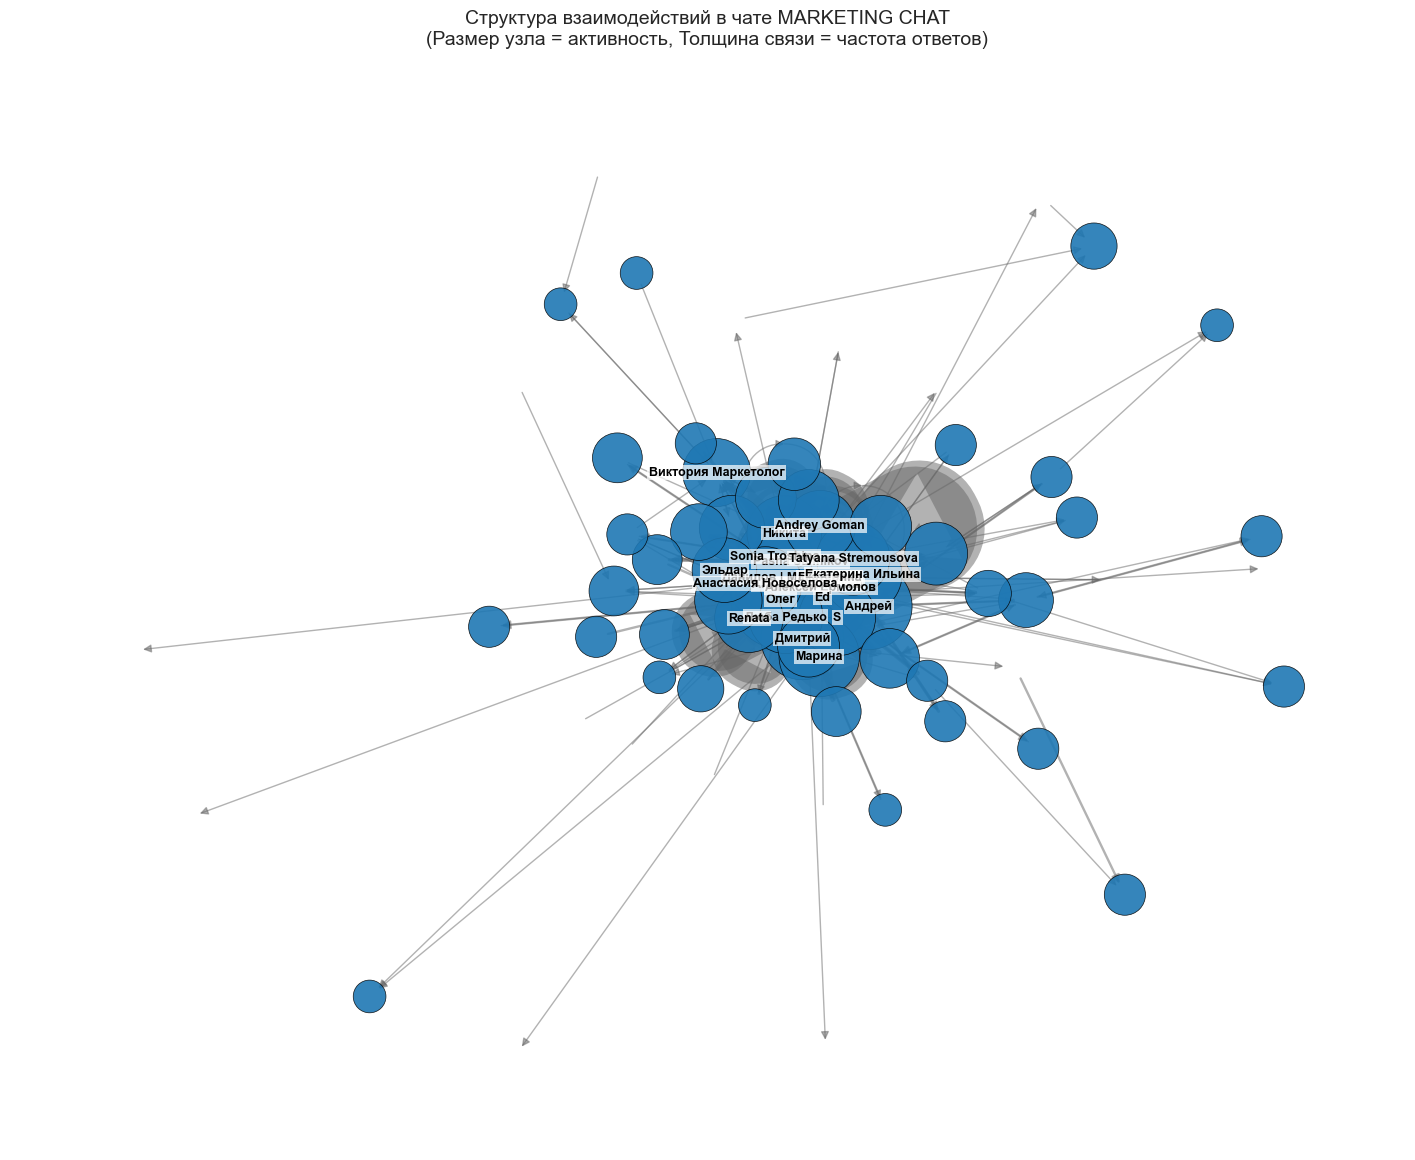

In [7]:
def visualize_network(df, chat_name):
    """Визуализация сетевой структуры чата"""
    print(f"\nВизуализация сети чата {chat_name}:")
    
    # Проверка данных
    if 'reply_to_message_id' not in df.columns or 'from_id' not in df.columns:
        print("Недостаточно данных для построения графа")
        return
    
    # Создание графа
    G = nx.DiGraph()
    
    # Добавление узлов
    user_message_count = df['from'].value_counts().to_dict()
    for user, count in user_message_count.items():
        G.add_node(user, size=count)
    
    # Добавление ребер
    replies = df[df['reply_to_message_id'].notna()]
    for _, row in replies.iterrows():
        original_msg = df[df['id'] == row['reply_to_message_id']]
        if not original_msg.empty:
            source = original_msg.iloc[0]['from']
            target = row['from']
            if G.has_edge(source, target):
                G[source][target]['weight'] += 1
            else:
                G.add_edge(source, target, weight=1)
    
    # Проверка на пустой граф
    if len(G.nodes()) == 0:
        print("Нет связей для визуализации")
        return
    
    # Настройка визуализации
    plt.figure(figsize=(18, 14))
    plt.title(f'Структура взаимодействий в чате {chat_name}\n'
              f'(Размер узла = активность, Толщина связи = частота ответов)', 
              pad=20, fontsize=14)
    
    # Расчет параметров
    node_sizes = [np.log(G.nodes[n]['size'])*800 for n in G.nodes()]
    edge_widths = [0.3 + G[u][v]['weight']*0.7 for u,v in G.edges()]
    pos = nx.spring_layout(G, k=0.7, iterations=100, seed=42)
    
    # Отрисовка элементов
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color='#1f78b4',
        alpha=0.9,
        edgecolors='black',
        linewidths=0.5
    )
    
    nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        edge_color='#666666',
        alpha=0.5,
        arrowstyle='-|>',
        arrowsize=12
    )
    
    # Подписи для важных узлов (топ 25%)
    degrees = [d for n,d in G.degree(weight='weight')]
    if degrees:  # Проверка на случай пустого списка
        threshold = np.percentile(degrees, 75)
        important_nodes = [n for n in G.nodes() if G.degree(n, weight='weight') > threshold]
        labels = {n: n for n in important_nodes}
        
        nx.draw_networkx_labels(
            G, pos,
            labels=labels,
            font_size=9,
            font_weight='bold',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
        )
    
    plt.axis('off')
    plt.savefig(f'network_{chat_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_network(manage_alumin, "MANAGEMENT ALUMNI")
visualize_network(data_practicum, "DATA PRACTICUM") 
visualize_network(marketing_chat, "MARKETING CHAT")


📊 Сетевой анализ в MANAGEMENT ALUMNI:
⚠️ Нет данных для сетевого анализа

📊 Сетевой анализ в DATA PRACTICUM:

🔄 Создание интерактивного графа...
✅ Интерактивный граф сохранен как interactive_network_DATA PRACTICUM.html


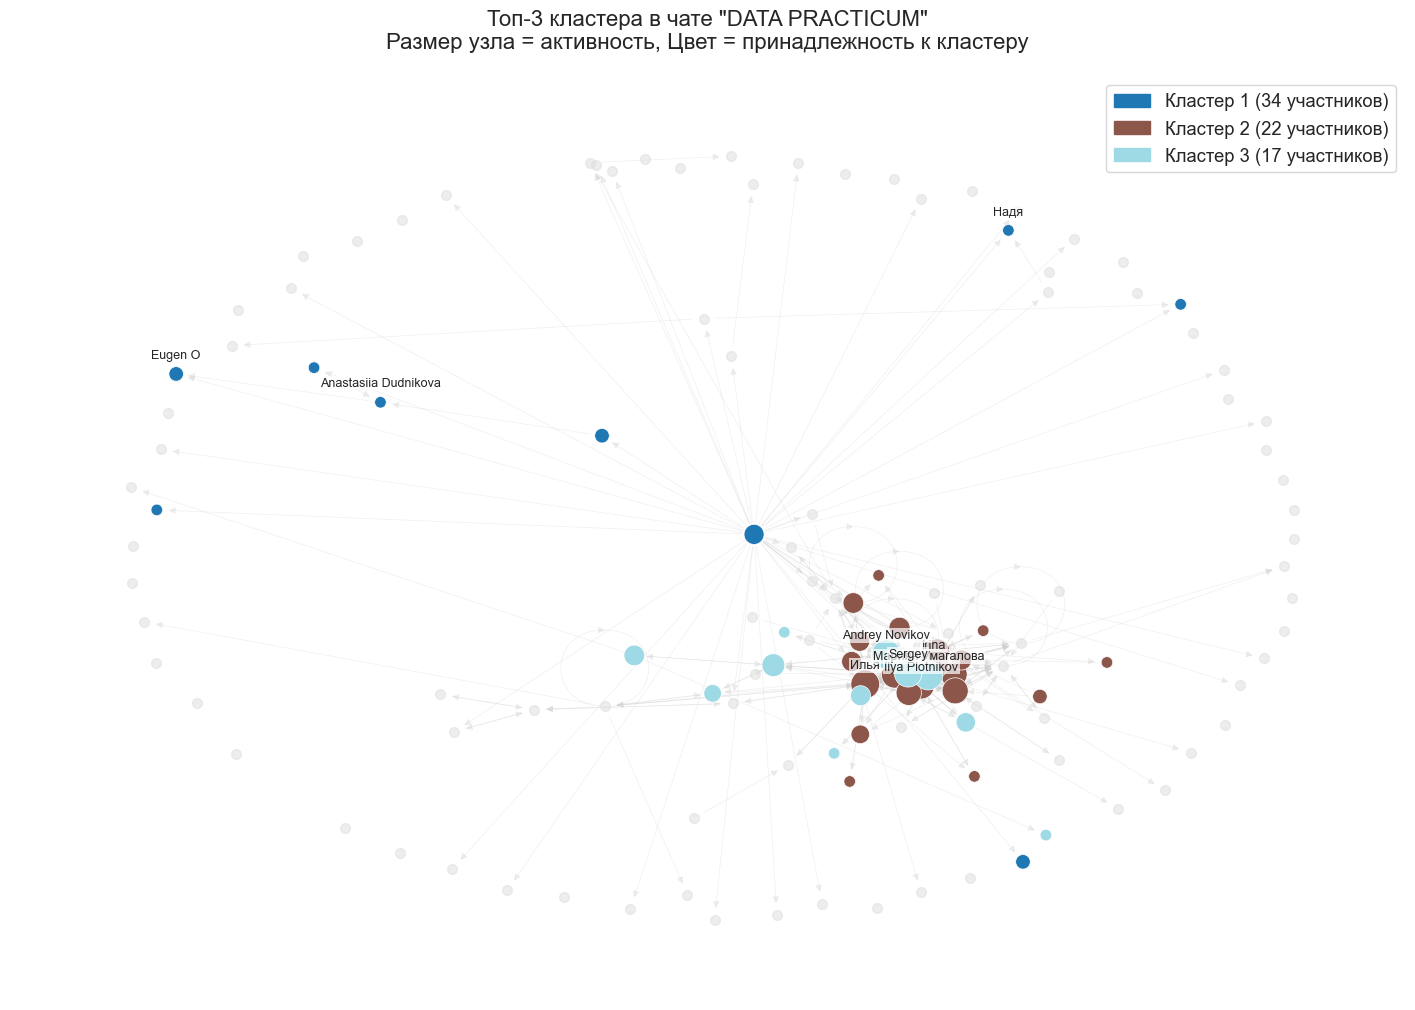

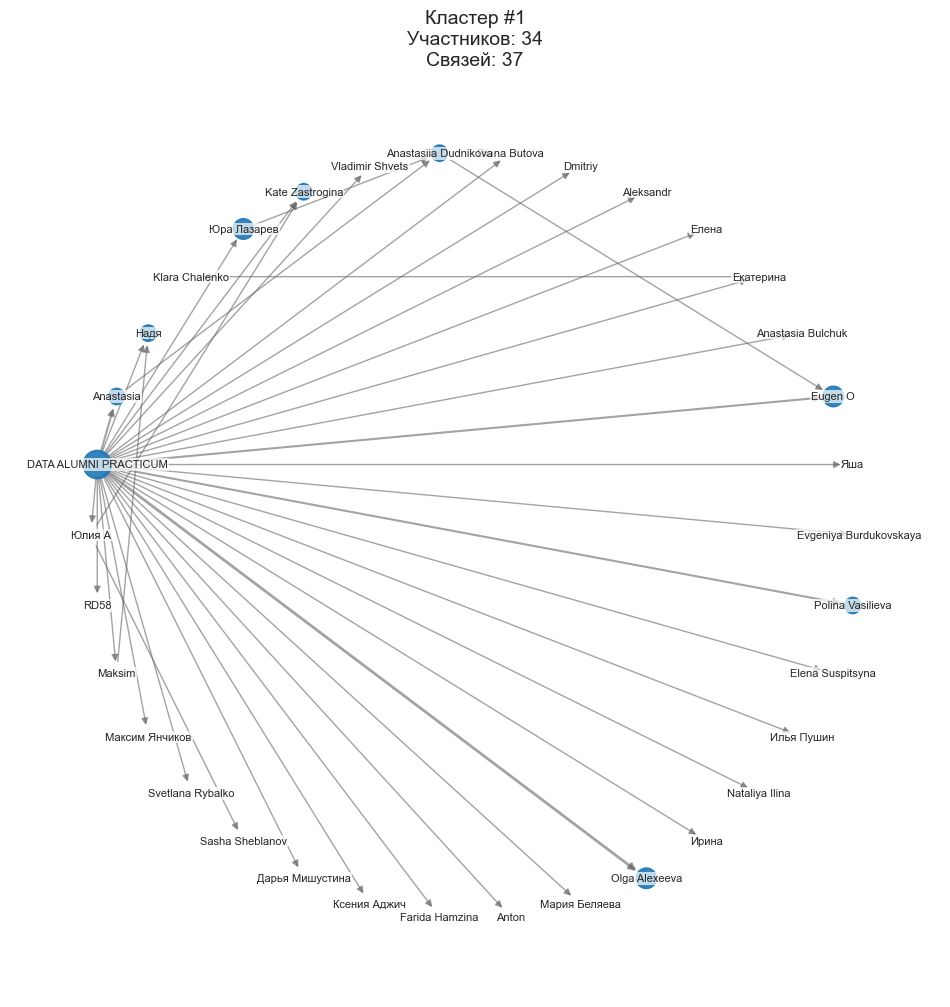

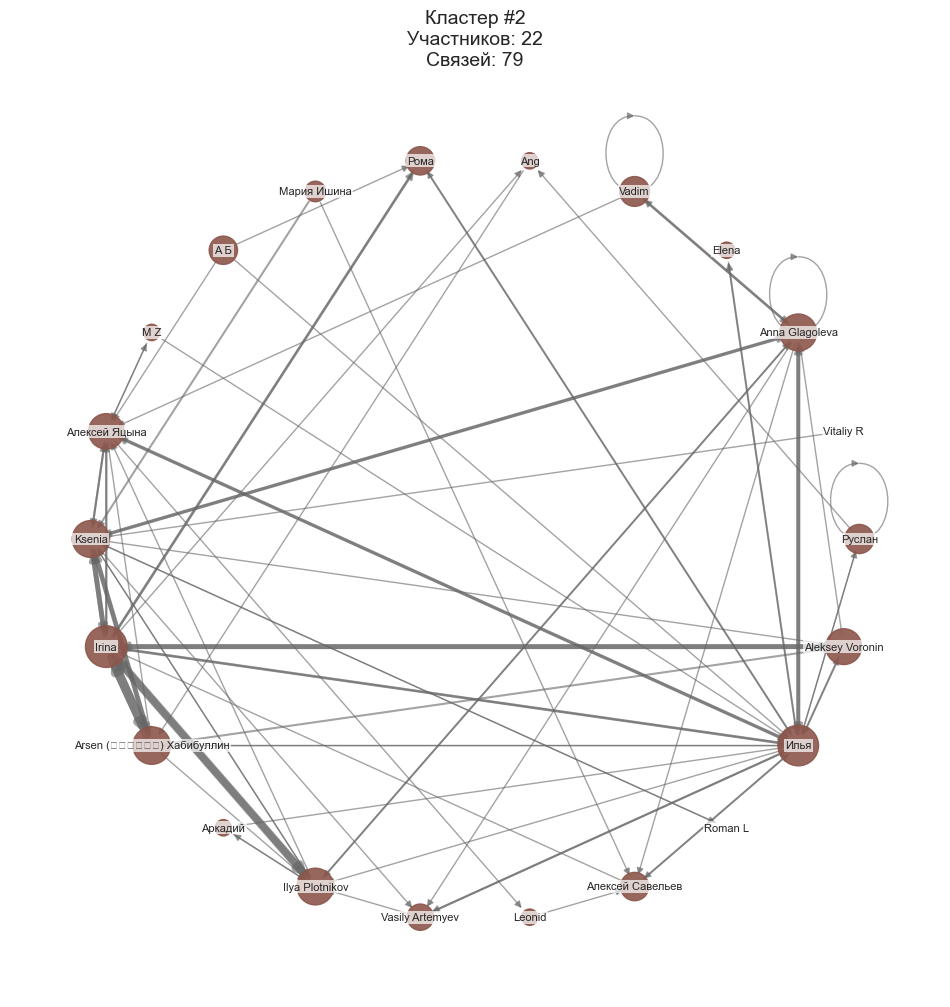

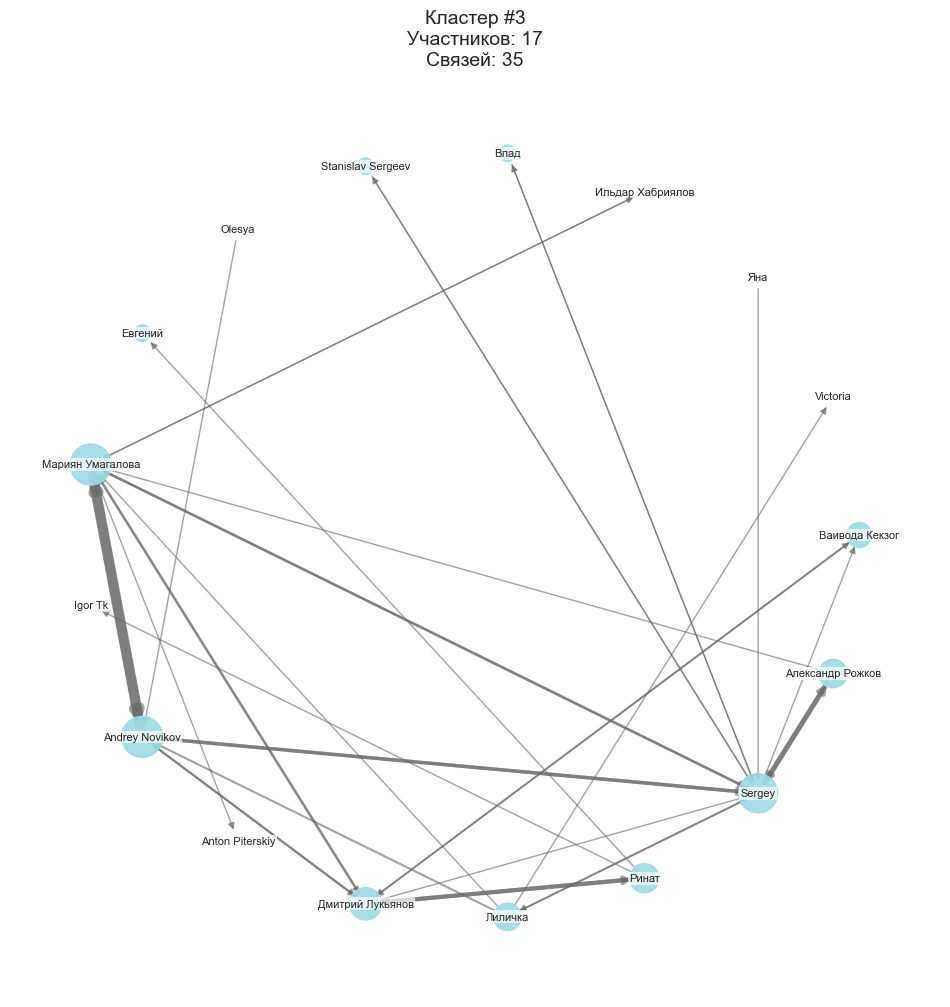


🔍 Топ-15 пользователей по влиянию в 'DATA PRACTICUM':



📊 Статистика сети 'DATA PRACTICUM':
• Пользователей: 131
• Взаимодействий: 312
• Плотность: 0.018
• Средняя степень: 4.8
• Диаметр: ∞
• Средний путь: ∞

📊 Сетевой анализ в MARKETING CHAT:

🔄 Создание интерактивного графа...
✅ Интерактивный граф сохранен как interactive_network_MARKETING CHAT.html


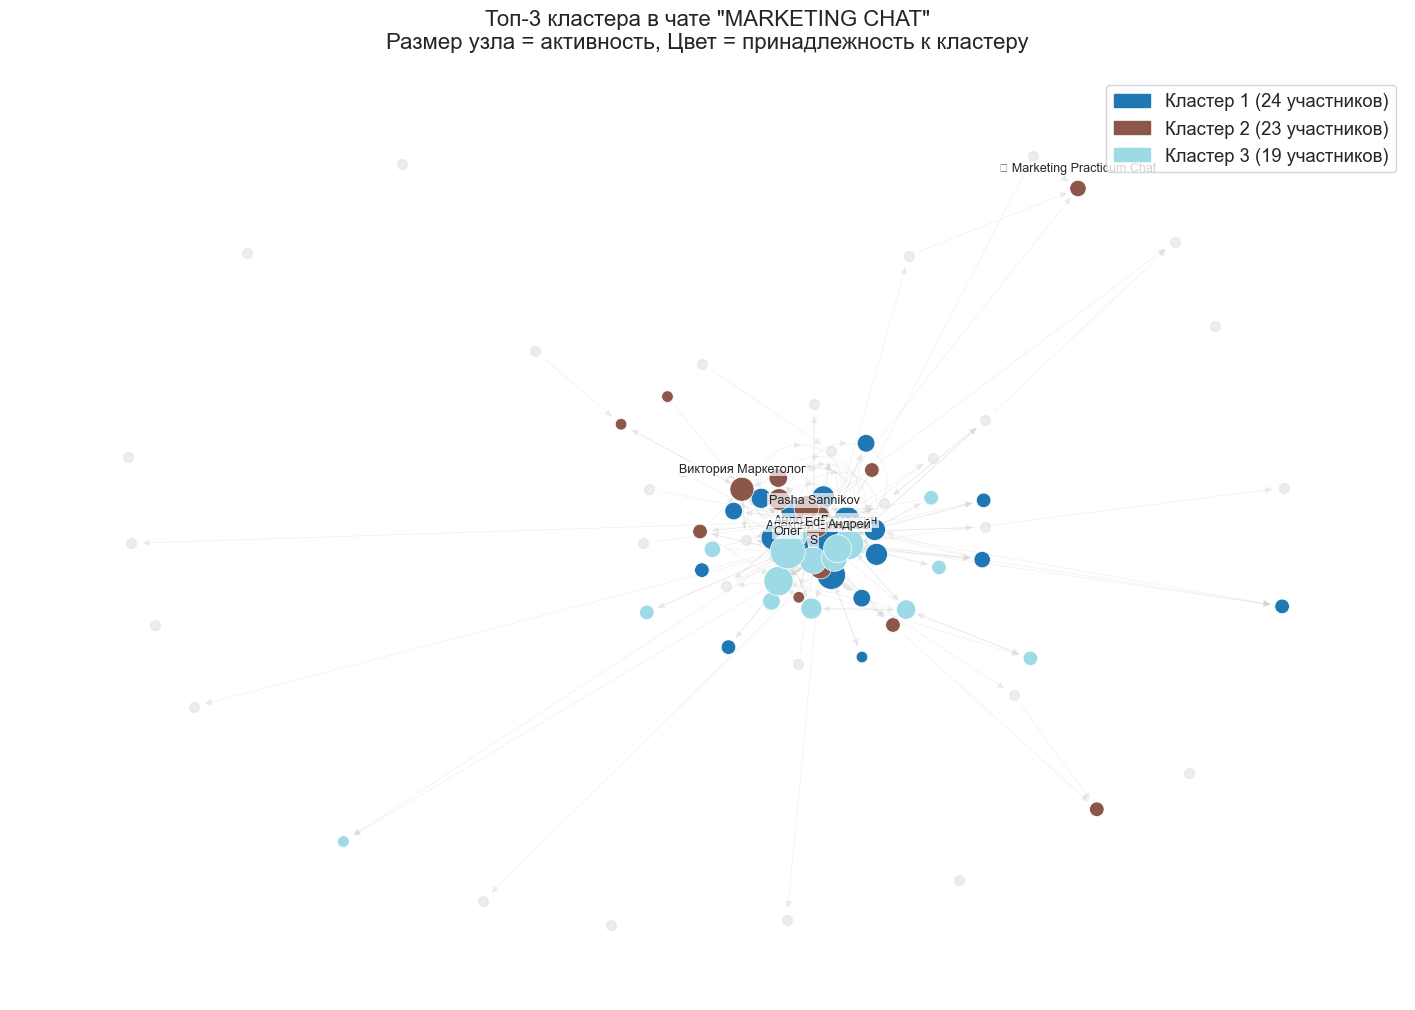

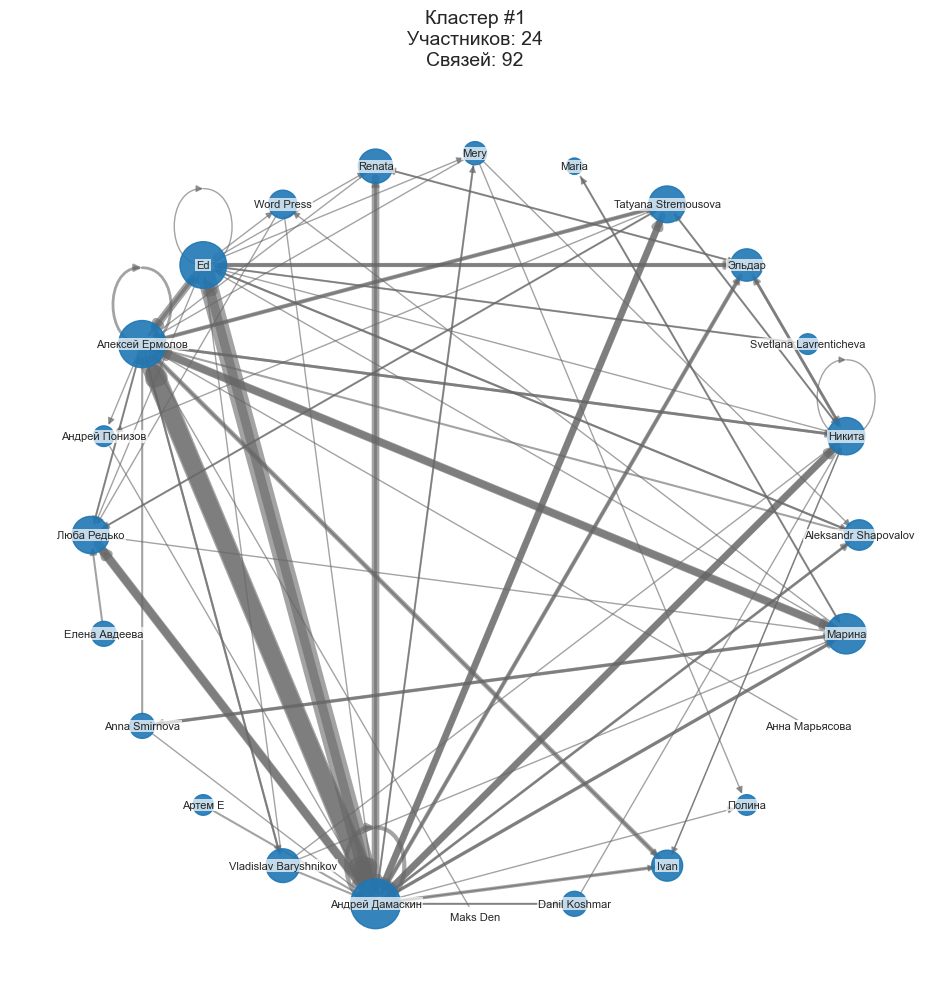

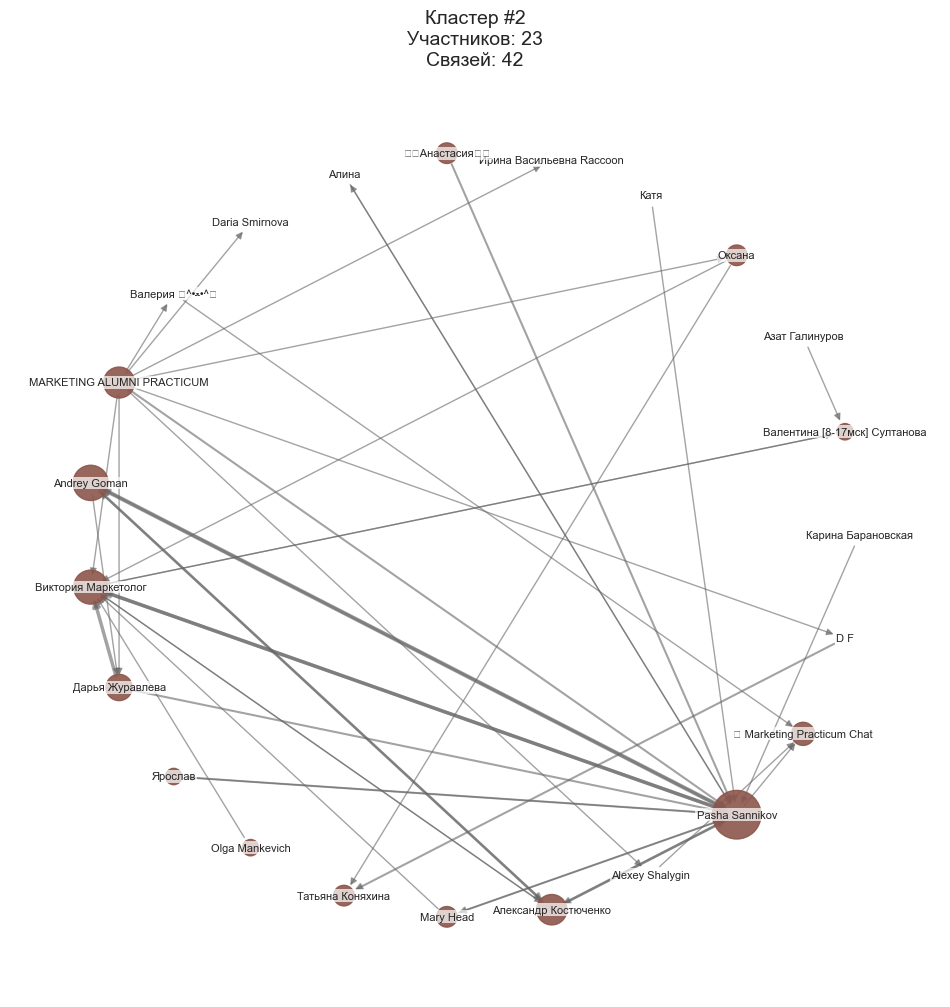

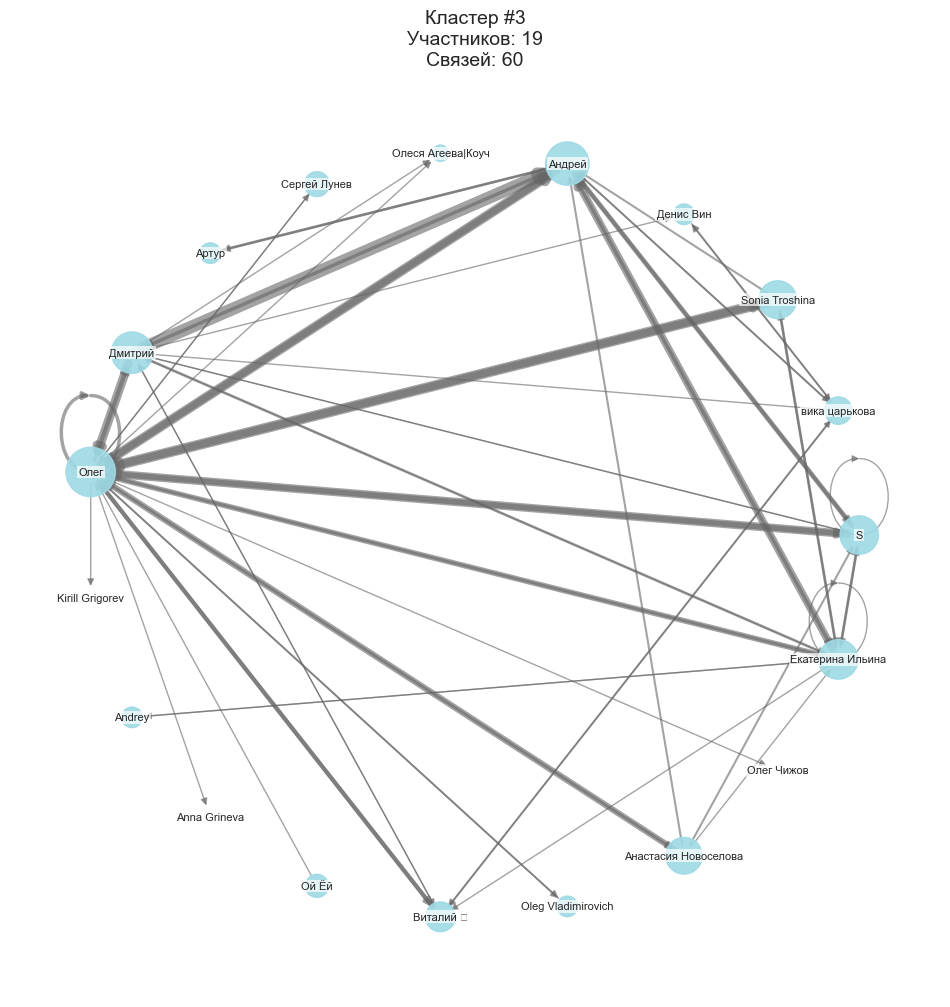


🔍 Топ-15 пользователей по влиянию в 'MARKETING CHAT':



📊 Статистика сети 'MARKETING CHAT':
• Пользователей: 85
• Взаимодействий: 385
• Плотность: 0.054
• Средняя степень: 9.1
• Диаметр: ∞
• Средний путь: ∞


In [8]:
def analyze_network(df, chat_name):
    """Интерактивный сетевой анализ с улучшенной визуализацией"""
    print(f"\n📊 Сетевой анализ в {chat_name}:")
    
    # Проверка данных и создание графа (как в предыдущей версии)
    if 'reply_to_message_id' not in df.columns or 'from_id' not in df.columns:
        print("⚠️ Нет данных для сетевого анализа")
        return None
    
    G = nx.DiGraph()
    user_message_count = df['from'].value_counts().to_dict()
    
    for user, count in user_message_count.items():
        G.add_node(user, size=count, title=f"{user}\nСообщений: {count}")
    
    replies = df[df['reply_to_message_id'].notna()]
    for _, row in replies.iterrows():
        original_msg = df[df['id'] == row['reply_to_message_id']]
        if not original_msg.empty:
            source = original_msg.iloc[0]['from']
            target = row['from']
            G.add_edge(source, target, weight=G.get_edge_data(source, target, {}).get('weight', 0) + 1)
    
    if len(G.nodes()) == 0:
        print("⚠️ Граф пустой - нет взаимодействий")
        return None

    # 1. ИНТЕРАКТИВНЫЙ ОБЩИЙ ГРАФ (pyvis)
    
    print("\n🔄 Создание интерактивного графа...")
    net = Network(height="800px", width="100%", bgcolor="#ffffff", font_color="#333333", directed=True)
    
    # Вычисляем метрики для визуализации
    pagerank = nx.pagerank(G)
    betweenness = nx.betweenness_centrality(G)
    
    # Добавляем узлы с параметрами
    for node in G.nodes():
        size = np.log(G.nodes[node]['size']) * 5
        net.add_node(
            node, 
            size=size,
            title=f"{node}\n"
                  f"Сообщений: {G.nodes[node]['size']}\n"
                  f"PageRank: {pagerank[node]:.3f}\n"
                  f"Betweenness: {betweenness[node]:.3f}",
            group=int(pagerank[node] * 100)  # Для группировки по кластерам
        )
    
    # Добавляем ребра
    for edge in G.edges(data=True):
        net.add_edge(edge[0], edge[1], width=edge[2]['weight']*0.5)
    
    # Настройки физики для лучшего отображения
    net.set_options("""
    {
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -2000,
          "centralGravity": 0.3,
          "springLength": 200
        },
        "minVelocity": 0.75
      }
    }
    """)
    
    # Сохраняем интерактивный граф
    net.save_graph(f"interactive_network_{chat_name}.html")
    print(f"✅ Интерактивный граф сохранен как interactive_network_{chat_name}.html")
    
    # 2. СТАТИЧНЫЕ КЛАСТЕРЫ (Matplotlib)
    if len(G) >= 3:
        # Выявляем топ-3 кластера
        communities = nx.algorithms.community.greedy_modularity_communities(G.to_undirected())
        top_clusters = sorted(communities, key=len, reverse=True)[:3]
        
        # Цветовая палитра для кластеров
        colors = cm.get_cmap('tab20', len(top_clusters))
        
        plt.figure(figsize=(18, 12))
        pos = nx.spring_layout(G, k=0.8, iterations=200, seed=42)
        
        # Рисуем все узлы серым (фон)
        nx.draw_networkx_nodes(G, pos, node_size=50, node_color='#dddddd', alpha=0.5)
        nx.draw_networkx_edges(G, pos, edge_color='#cccccc', alpha=0.3, width=0.5)
        
        # Выделяем кластеры
        legend_handles = []
        for i, cluster in enumerate(top_clusters):
            cluster_color = colors(i)
            nx.draw_networkx_nodes(
                G, pos, 
                nodelist=cluster,
                node_size=[np.log(G.nodes[n]['size'])*100 for n in cluster],
                node_color=[cluster_color for _ in cluster],
                edgecolors='white',
                linewidths=0.5,
                label=f'Кластер {i+1}'
            )
            # Подписи для топ-3 узлов в кластере
            top_in_cluster = sorted(cluster, key=lambda x: pagerank[x], reverse=True)[:3]
            for node in top_in_cluster:
                plt.text(
                    pos[node][0], pos[node][1]+0.03,
                    node, 
                    fontsize=9, ha='center', va='bottom',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                )
            legend_handles.append(mpatches.Patch(color=cluster_color, label=f'Кластер {i+1} ({len(cluster)} участников)'))
        
        plt.title(
            f'Топ-3 кластера в чате "{chat_name}"\n'
            'Размер узла = активность, Цвет = принадлежность к кластеру',
            fontsize=16, pad=20
        )
        plt.legend(handles=legend_handles, loc='upper right')
        plt.axis('off')
        plt.savefig(f'clusters_{chat_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Детальная визуализация каждого кластера
        for i, cluster in enumerate(top_clusters, 1):
            cluster_graph = G.subgraph(cluster)
            plt.figure(figsize=(12, 12))
            
            # Круговая диаграмма для кластера
            pos_circular = nx.circular_layout(cluster_graph)
            
            nx.draw_networkx_nodes(
                cluster_graph, pos_circular,
                node_size=[np.log(cluster_graph.nodes[n]['size'])*200 for n in cluster_graph.nodes()],
                node_color=colors(i-1),
                alpha=0.9
            )
            
            nx.draw_networkx_edges(
                cluster_graph, pos_circular,
                width=[0.5 + cluster_graph[u][v]['weight']*0.5 for u,v in cluster_graph.edges()],
                edge_color='#666666',
                alpha=0.6
            )
            
            # Подписи без наложений
            for node in cluster_graph.nodes():
                plt.text(
                    pos_circular[node][0], pos_circular[node][1],
                    node, 
                    fontsize=8, ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
                )
            
            plt.title(
                f'Кластер #{i}\n'
                f'Участников: {len(cluster)}\n'
                f'Связей: {cluster_graph.number_of_edges()}',
                fontsize=14
            )
            plt.axis('off')
            plt.savefig(f'cluster_{i}_detail_{chat_name}.png', dpi=300)
            plt.show()
    
    # 3. АНАЛИТИКА (таблицы + метрики)
    centrality_metrics = {
        'degree': nx.degree_centrality(G),
        'betweenness': nx.betweenness_centrality(G),
        'closeness': nx.closeness_centrality(G),
        'pagerank': nx.pagerank(G),
        'in_degree': dict(G.in_degree()),
        'out_degree': dict(G.out_degree())
    }
    
    centrality_df = pd.DataFrame({
        'user': list(centrality_metrics['degree'].keys()),
        'messages': [user_message_count.get(u, 0) for u in centrality_metrics['degree'].keys()],
        'degree': list(centrality_metrics['degree'].values()),
        'betweenness': list(centrality_metrics['betweenness'].values()),
        'closeness': list(centrality_metrics['closeness'].values()),
        'pagerank': list(centrality_metrics['pagerank'].values()),
        'in_degree': list(centrality_metrics['in_degree'].values()),
        'out_degree': list(centrality_metrics['out_degree'].values())
    }).sort_values('pagerank', ascending=False)
    
    # Форматируем таблицу
    styled_df = (centrality_df.head(15)
                 .style
                 .background_gradient(cmap='Blues', subset=['degree', 'betweenness', 'closeness', 'pagerank'])
                 .format({col: '{:.3f}' for col in ['degree', 'betweenness', 'closeness', 'pagerank']}))
    
    print(f"\n🔍 Топ-15 пользователей по влиянию в '{chat_name}':")
    display(styled_df)
    
    # Сохранение в CSV
    centrality_df.to_csv(f'network_metrics_{chat_name}.csv', index=False)
    
    # Общая статистика
    print(f"\n📊 Статистика сети '{chat_name}':")
    print(f"• Пользователей: {len(G.nodes())}")
    print(f"• Взаимодействий: {len(G.edges())}")
    print(f"• Плотность: {nx.density(G):.3f}")
    print(f"• Средняя степень: {sum(dict(G.degree()).values())/len(G):.1f}")
    print(f"• Диаметр: {nx.diameter(G) if nx.is_connected(G.to_undirected()) else '∞'}")
    print(f"• Средний путь: {nx.average_shortest_path_length(G) if nx.is_connected(G.to_undirected()) else '∞'}")
    
    return centrality_df

network_manage = analyze_network(manage_alumin, "MANAGEMENT ALUMNI")
network_data = analyze_network(data_practicum, "DATA PRACTICUM")
network_marketing = analyze_network(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 6: ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ
# ==============================================


ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ

Дополнительный анализ MANAGEMENT ALUMNI:
Средняя длина сообщения: 39.8 символов


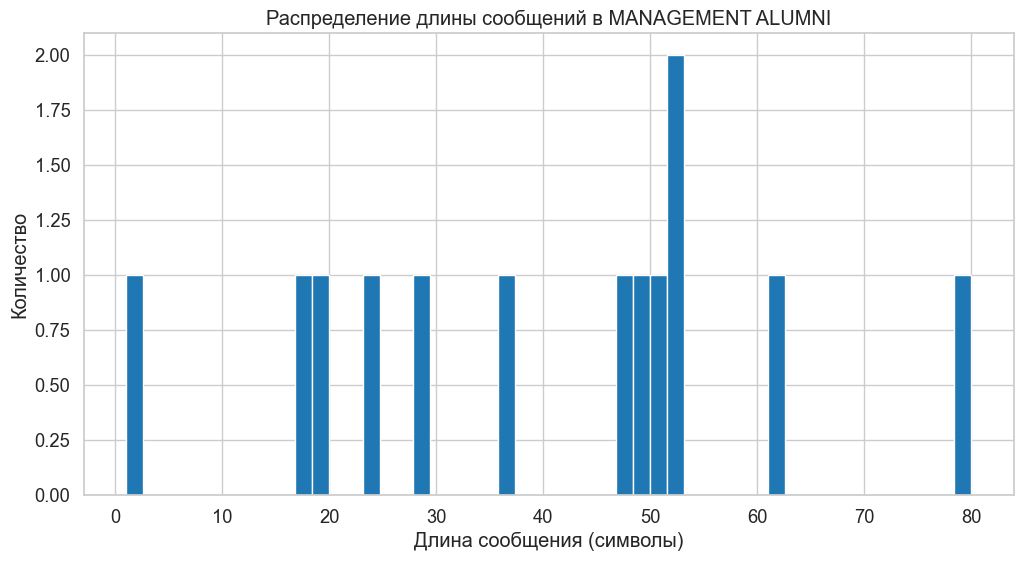

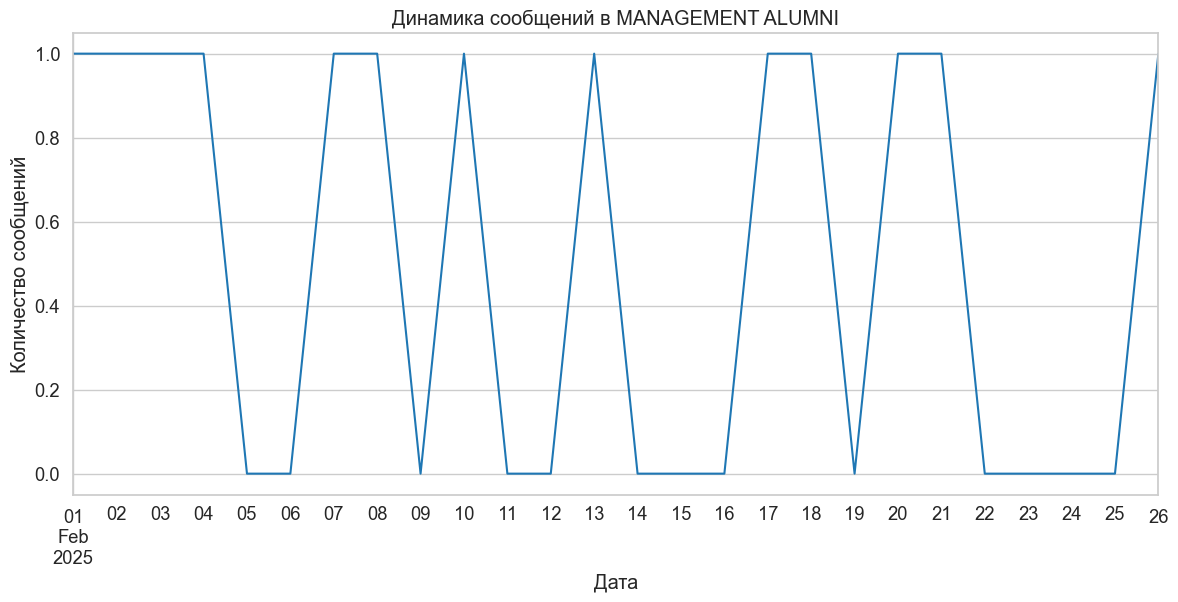

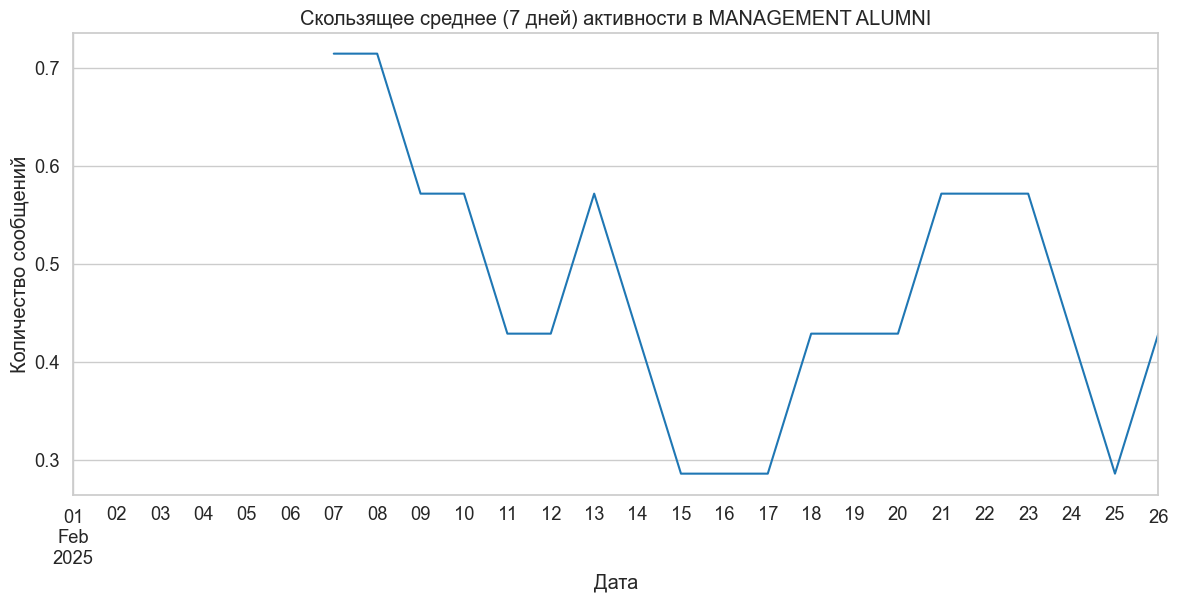


Дополнительный анализ DATA PRACTICUM:
Средняя длина сообщения: 59.6 символов


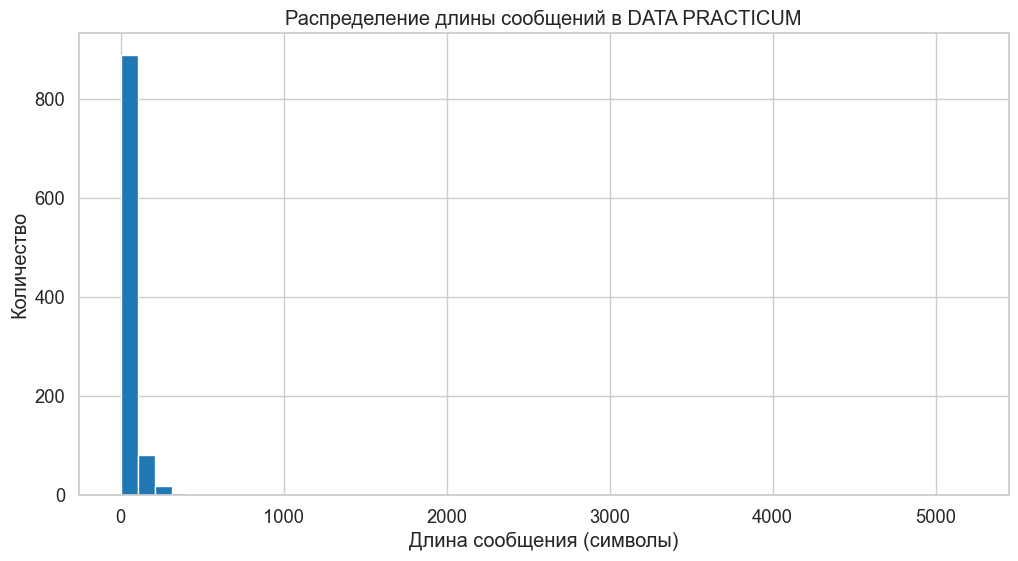

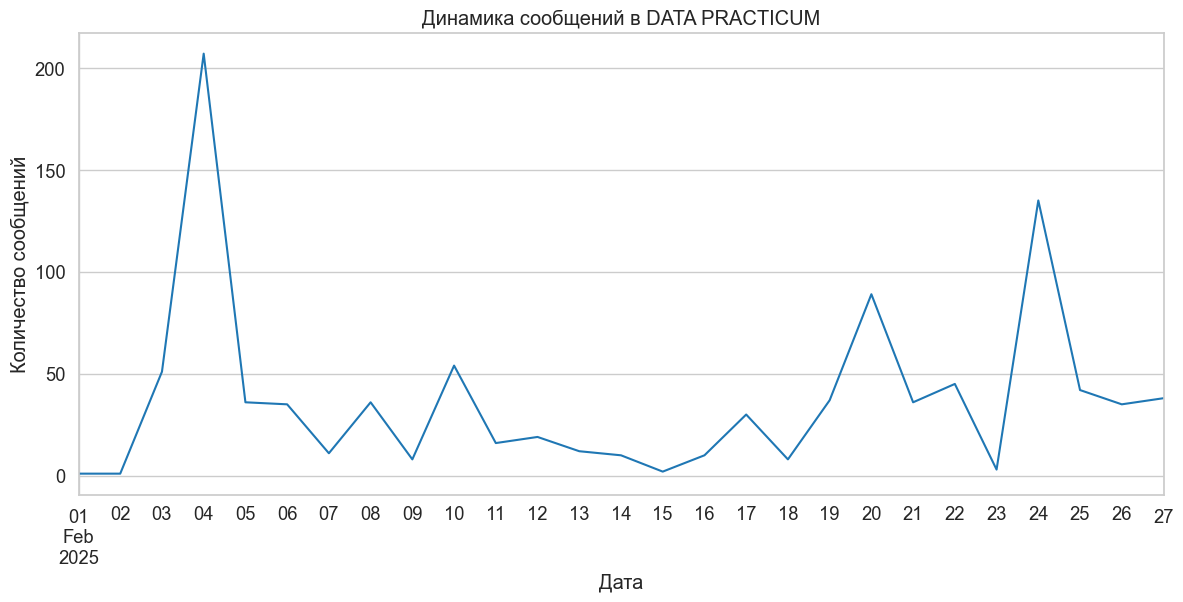

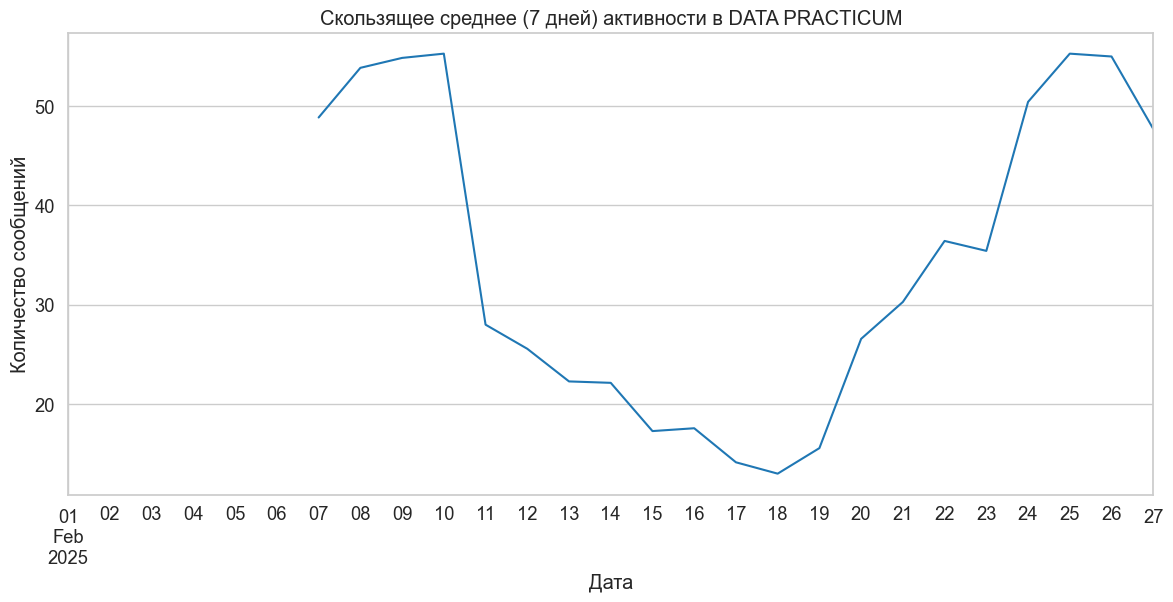


Дополнительный анализ MARKETING CHAT:
Средняя длина сообщения: 75.6 символов


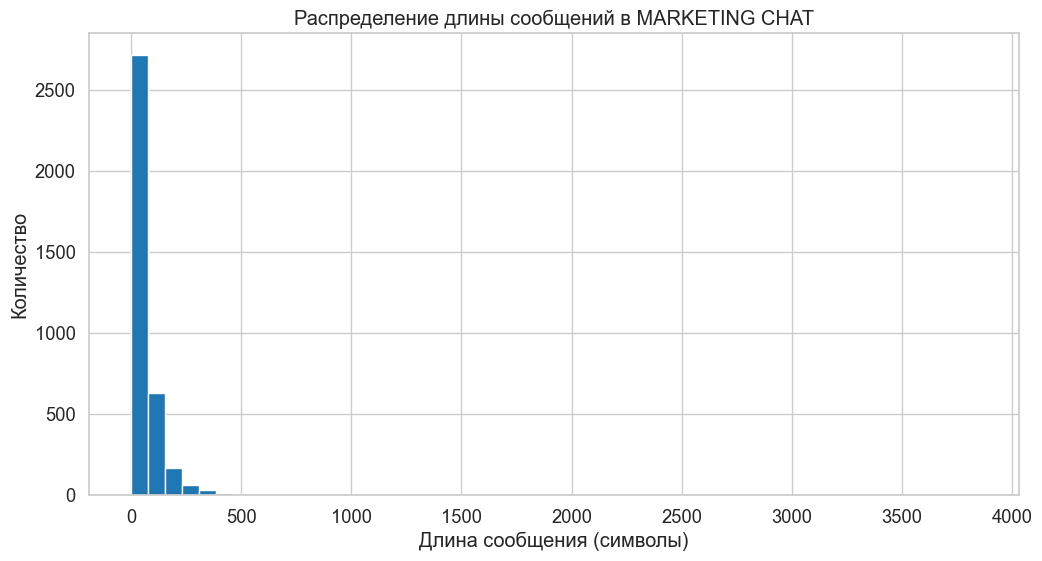

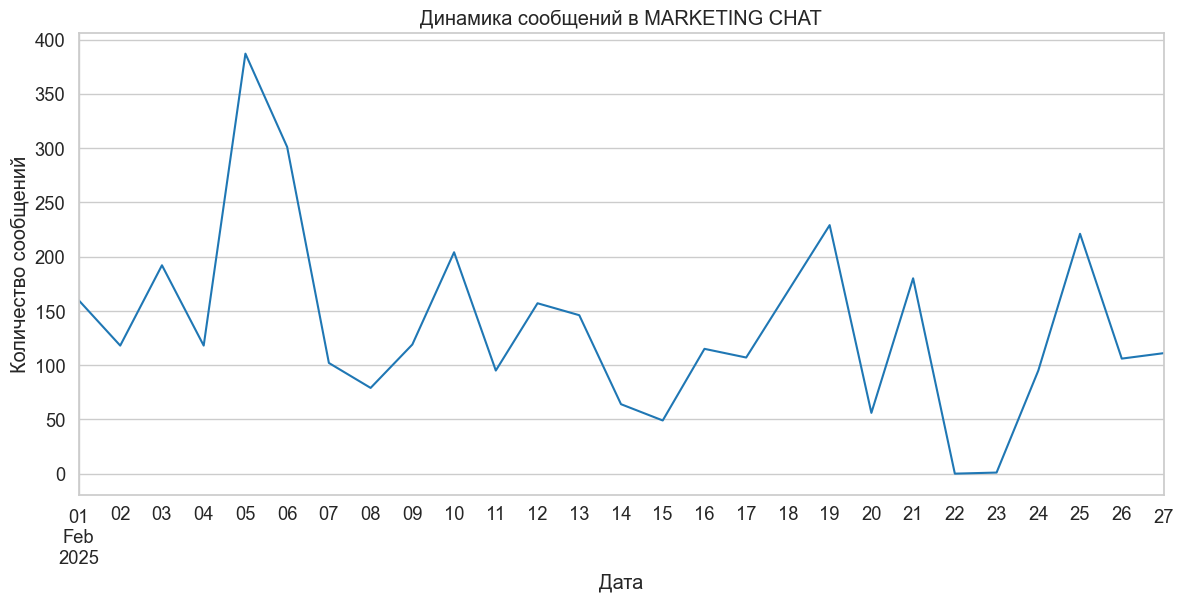

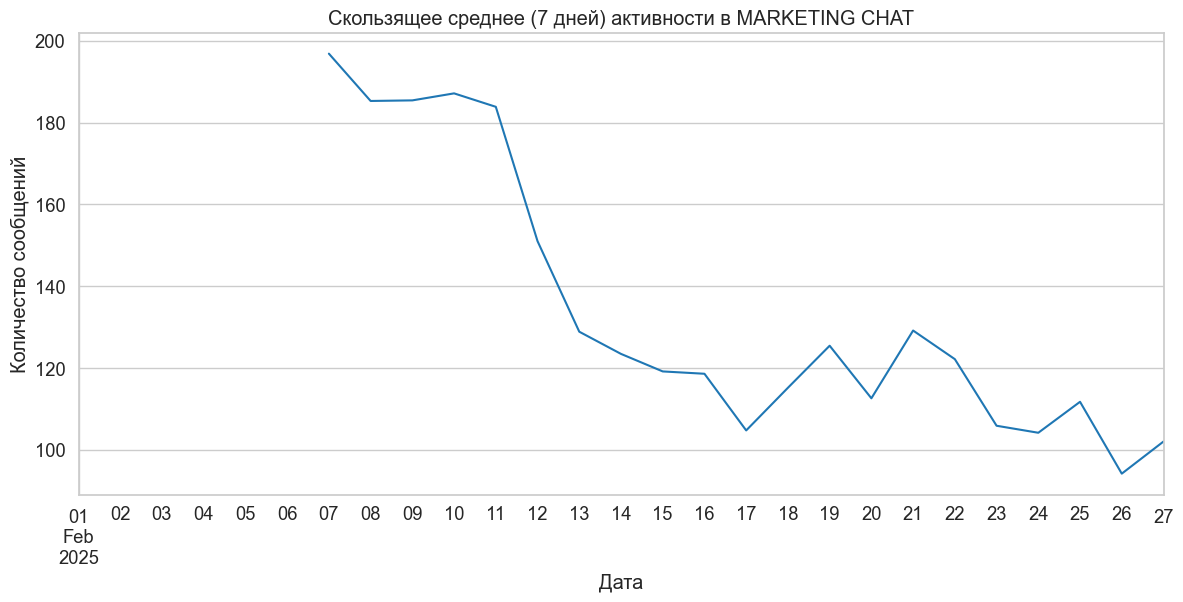

In [9]:

def additional_analysis(df, chat_name):
    """Дополнительные метрики"""
    print(f"\nДополнительный анализ {chat_name}:")
    
    # Средняя длина сообщения
    if 'text_clean' in df.columns:
        df['msg_length'] = df['text_clean'].str.len()
        avg_length = df['msg_length'].mean()
        print(f"Средняя длина сообщения: {avg_length:.1f} символов")
        
        plt.figure(figsize=(12, 6))
        df['msg_length'].hist(bins=50)
        plt.title(f'Распределение длины сообщений в {chat_name}')
        plt.xlabel('Длина сообщения (символы)')
        plt.ylabel('Количество')
        plt.show()
    
    # Динамика сообщений по времени
    if 'date' in df.columns:
        daily_counts = df.resample('D', on='date').size()
        
        plt.figure(figsize=(14, 6))
        daily_counts.plot()
        plt.title(f'Динамика сообщений в {chat_name}')
        plt.xlabel('Дата')
        plt.ylabel('Количество сообщений')
        plt.grid(True)
        plt.show()
        
        # Скользящее среднее для сглаживания
        rolling_avg = daily_counts.rolling(window=7).mean()
        
        plt.figure(figsize=(14, 6))
        rolling_avg.plot()
        plt.title(f'Скользящее среднее (7 дней) активности в {chat_name}')
        plt.xlabel('Дата')
        plt.ylabel('Количество сообщений')
        plt.grid(True)
        plt.show()

print("\n" + "="*50)
print("ДОПОЛНИТЕЛЬНЫЙ АНАЛИЗ")
print("="*50)

additional_analysis(manage_alumin, "MANAGEMENT ALUMNI")
additional_analysis(data_practicum, "DATA PRACTICUM")
additional_analysis(marketing_chat, "MARKETING CHAT")

# ==============================================
# БЛОК 7: СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЧАТОВ
# ==============================================

In [10]:

def compare_chats():
    """Сравнительный анализ всех чатов"""
    comparison = []
    
    # Собираем данные по всем чатам
    chats = {
        "MANAGEMENT ALUMNI": {
            'active_users': active_users_manage,
            'time_patterns': time_patterns_manage,
            'text_analysis': text_analysis_manage
        },
        "DATA PRACTICUM": {
            'active_users': active_users_data,
            'time_patterns': time_patterns_data,
            'text_analysis': text_analysis_data
        },
        "MARKETING CHAT": {
            'active_users': active_users_marketing,
            'time_patterns': time_patterns_marketing,
            'text_analysis': text_analysis_marketing
        }
    }
    
    for chat_name, results in chats.items():
        row = {
            'chat': chat_name,
            'total_messages': results['active_users'].sum(),
            'active_users': len(results['active_users']),
            'top_user': results['active_users'].index[0],
            'top_user_msgs': results['active_users'].iloc[0],
            'peak_hour': results['time_patterns']['hourly_activity'].idxmax(),
            'peak_day': results['time_patterns']['daily_activity'].idxmax()
        }
        
        if results['text_analysis']:
            row['top_word'] = results['text_analysis'][0][0]
            row['top_word_count'] = results['text_analysis'][0][1]
        
        comparison.append(row)
    
    return pd.DataFrame(comparison)

print("\n" + "="*50)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЧАТОВ")
print("="*50)

comparison_df = compare_chats()
print("\nСравнительная статистика чатов:")
print(comparison_df)

# Сохранение результатов
comparison_df.to_excel('chat_comparison.xlsx', index=False)
print("\nРезультаты сохранены в chat_comparison.xlsx")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ ЧАТОВ

Сравнительная статистика чатов:
                chat  total_messages  active_users  \
0  MANAGEMENT ALUMNI              13             1   
1     DATA PRACTICUM             702            20   
2     MARKETING CHAT            3425            20   

                      top_user  top_user_msgs  peak_hour   peak_day  \
0  MANAGEMENT ALUMNI PRACTICUM             13         14     Monday   
1                        Irina             89         12    Tuesday   
2              Андрей Дамаскин            614         17  Wednesday   

     top_word  top_word_count  
0  практикума               2  
1    yndxcbot              29  
2      яндекс              87  

Результаты сохранены в chat_comparison.xlsx


In [11]:
! jupyter nbconvert --to html EDA.ipynb

[NbConvertApp] Converting notebook EDA.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 37 image(s).
[NbConvertApp] Writing 6613902 bytes to EDA.html
